In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from os import listdir
from os.path import isfile, join
from datetime import datetime 
import pandas as pd
from matplotlib import pyplot as plt
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.graphics.tsaplots import plot_pacf
from pymongo import MongoClient
import Config
import numpy as np
from scipy import stats 
from numpy.random import seed
from numpy.random import randn
from numpy.random import normal
from scipy.stats import ttest_1samp
import warnings
import seaborn as sns
pd.set_option('display.max_columns', None)
import statsmodels.api as sm
from scipy import stats
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.stattools import kpss
pd.options.display.float_format = '{:.3f}'.format

def kpss_test(series, **kw):    
    statistic, p_value, n_lags, critical_values = kpss(series, **kw)
    # Format Output
    print(f'KPSS Statistic: {statistic}')
    print(f'p-value: {p_value}')
    print(f'num lags: {n_lags}')
    print('Critial Values:')
    for key, value in critical_values.items():
        print(f'   {key} : {value}')
    print(f'Result: The series is {"not " if p_value < 0.05 else ""}stationary')
    
def pred_errors(X):
    y_pred=[]
    y_orig=[]
    train, test = X[0:100], X[100:len(X)]
    history = [x for x in train]
    
    for t in range(len(test)):
        model = ARIMA(history, order=(1,1,0))
        model_fit = model.fit()
        output = model_fit.forecast()
        yhat = output[0]
        y_pred.append(yhat)
        obs = test[t]
        history.append(obs)
        y_orig.append(obs)
    
    return [a-b for a,b in zip(y_orig,y_pred)]

warnings.filterwarnings("ignore")
client = MongoClient(Config.DB_Hostname,Config.DB_Port)

In [7]:
path="/Users/praneetshaw/Desktop/Strategy/CFiles/"
onlyfiles = [f for f in listdir(path) if isfile(join(path, f))]
onlyfiles = [s for s in onlyfiles if ".csv" in s]

dates=[ datetime.strptime(o[:-18],"%Y-%m-%d") for o in onlyfiles]
#dates=[ datetime.strptime(o[:-14],"%Y-%m-%d") for o in onlyfiles]

onlyfiles= [o for d,o in sorted(zip(dates,onlyfiles))]

df=pd.DataFrame()
for f in onlyfiles:
    df=pd.concat([df,pd.read_csv(f)])

df.sort_values(['date','strategy_variant'],inplace=True)

In [8]:
df[['pos_diff','mov_diff','prof_diff']].describe()

pos_diff  mov_diff  prof_diff
count 89472.000 89472.000  89472.000
mean      0.007     0.015      0.011
std       0.008     0.020      0.014
min       0.000     0.000      0.000
25%       0.005     0.005      0.005
50%       0.005     0.010      0.005
75%       0.010     0.015      0.010
max       0.075     0.175      0.085

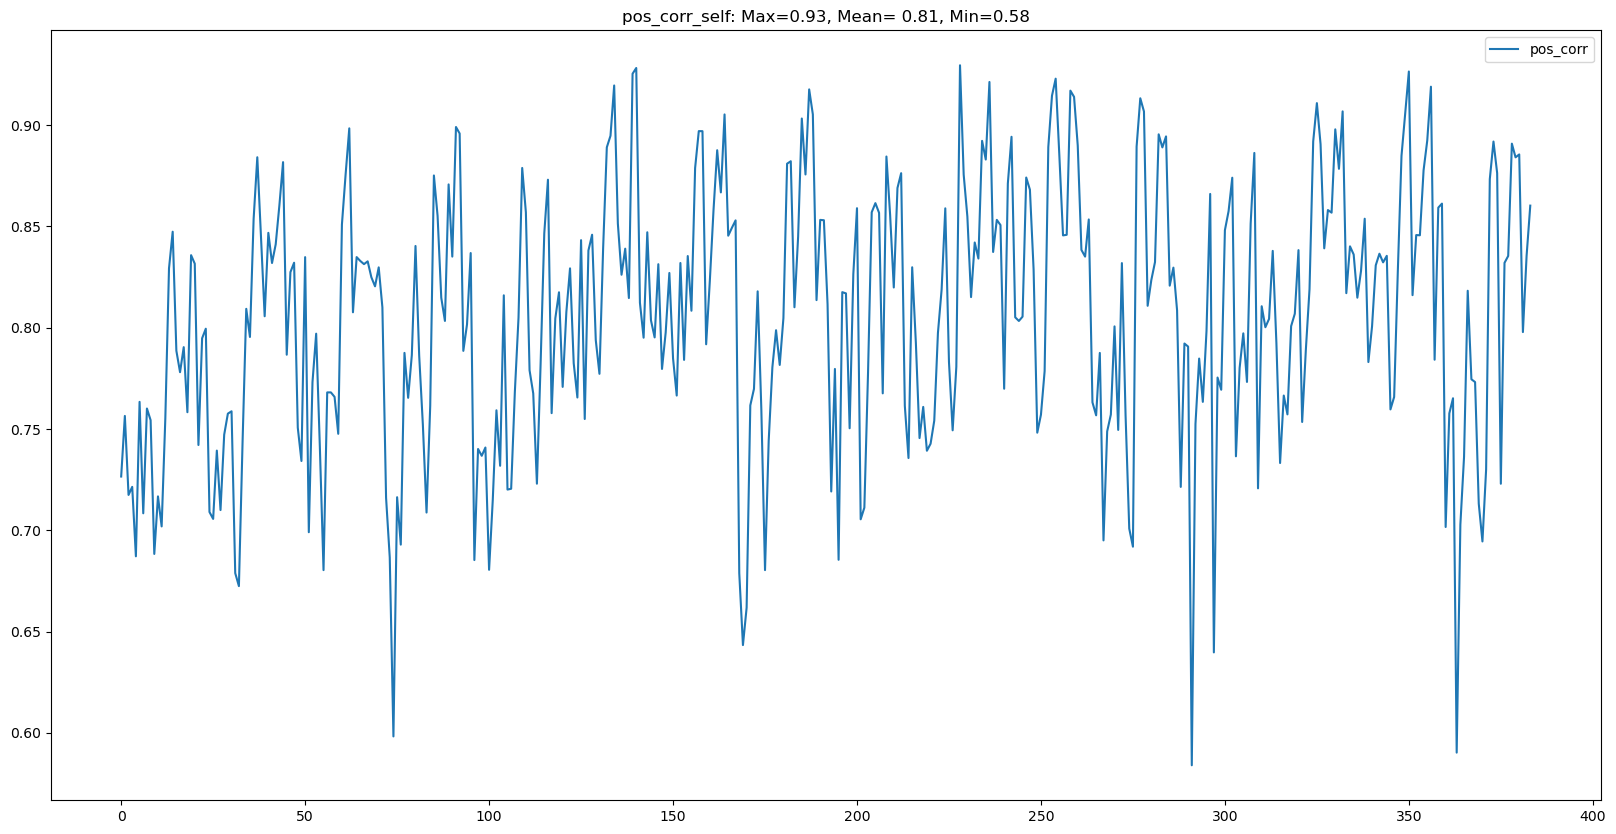

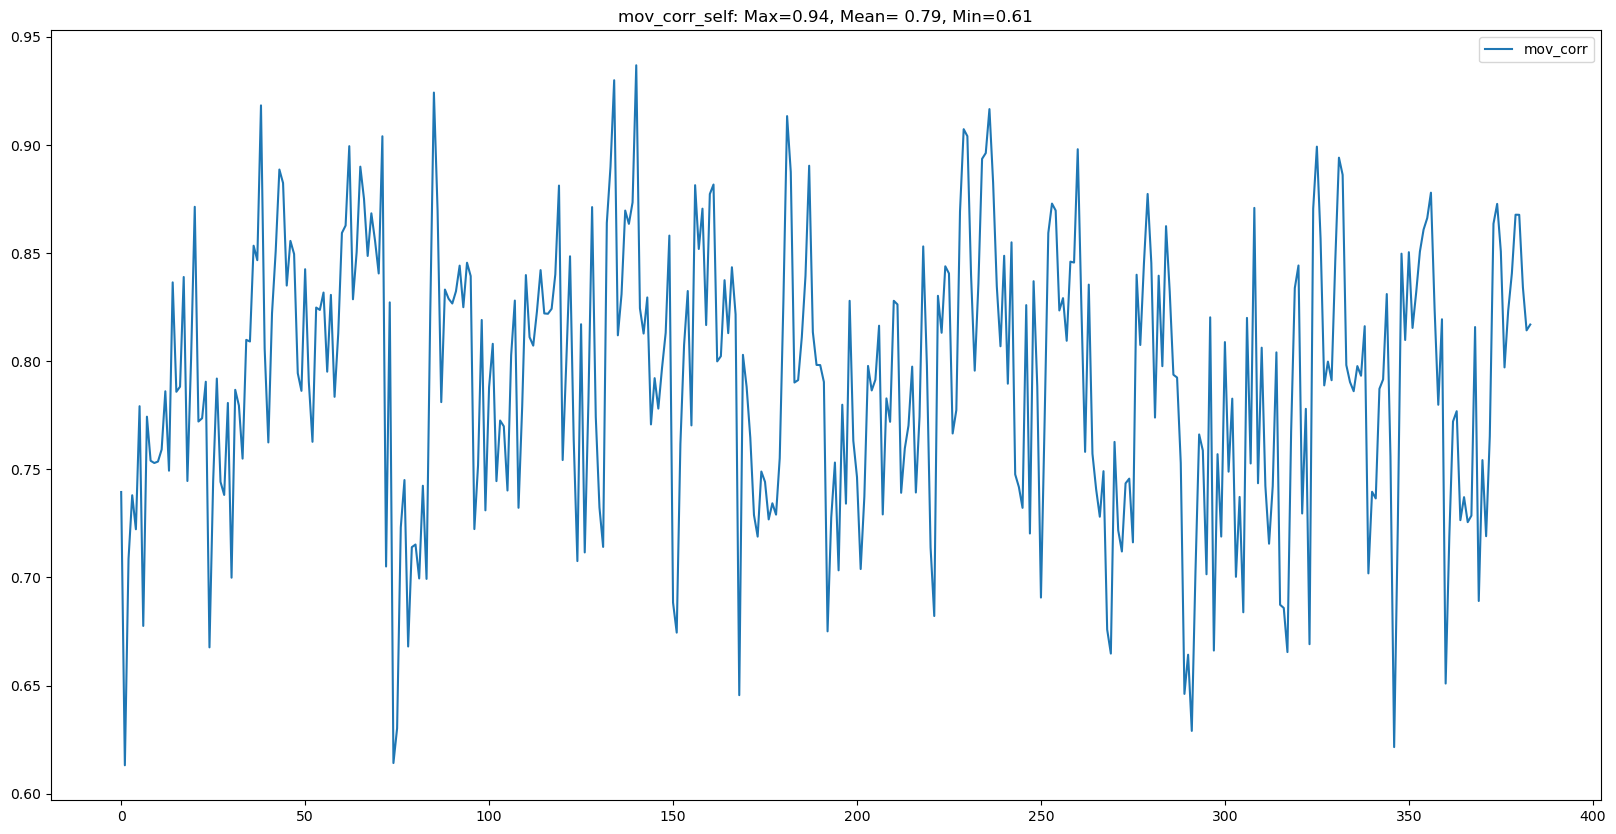

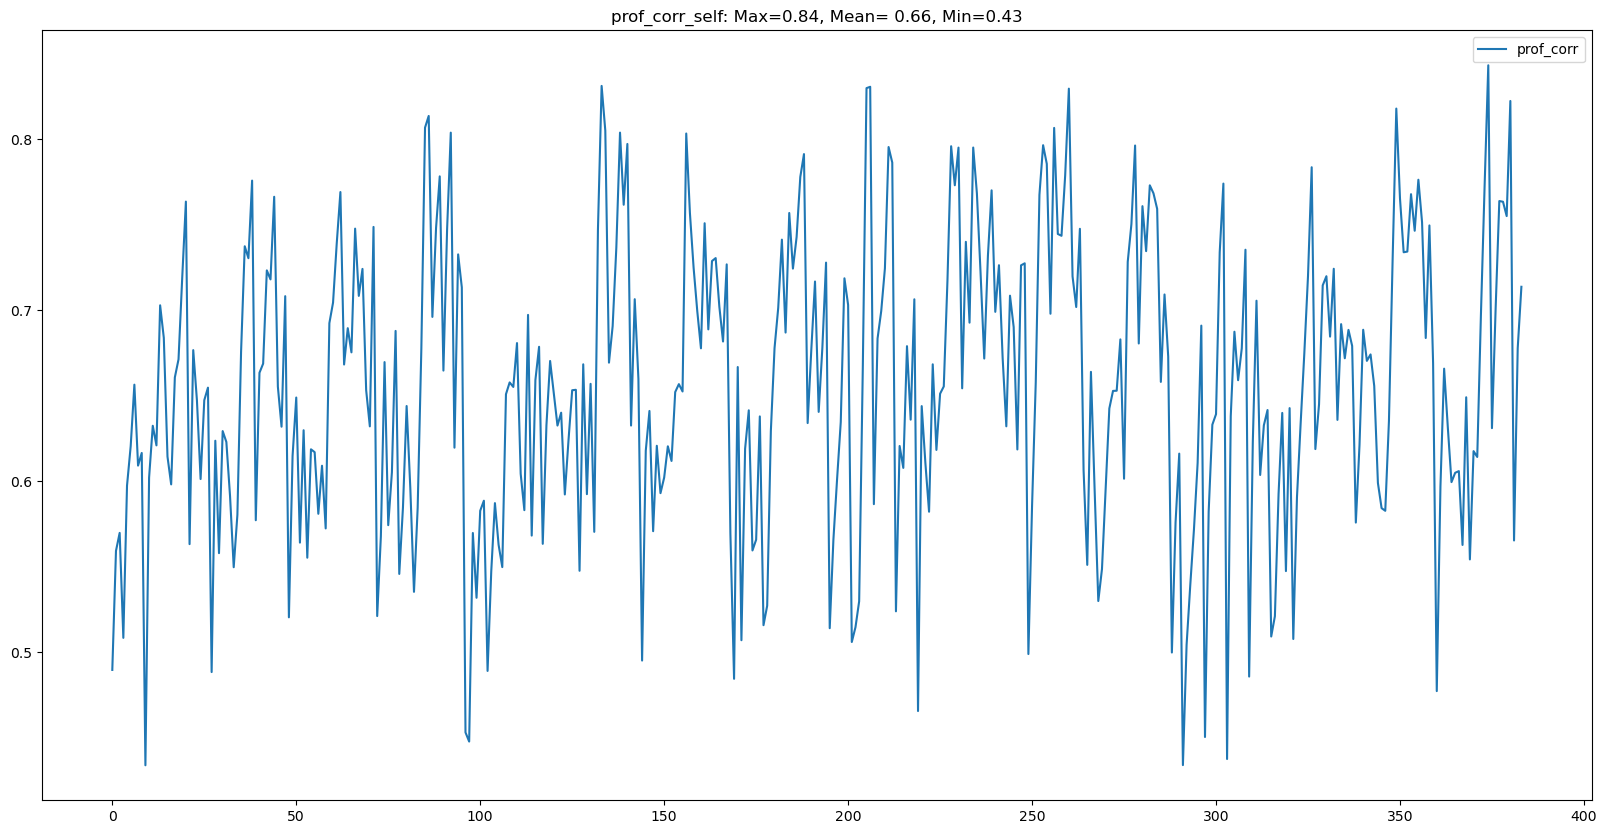

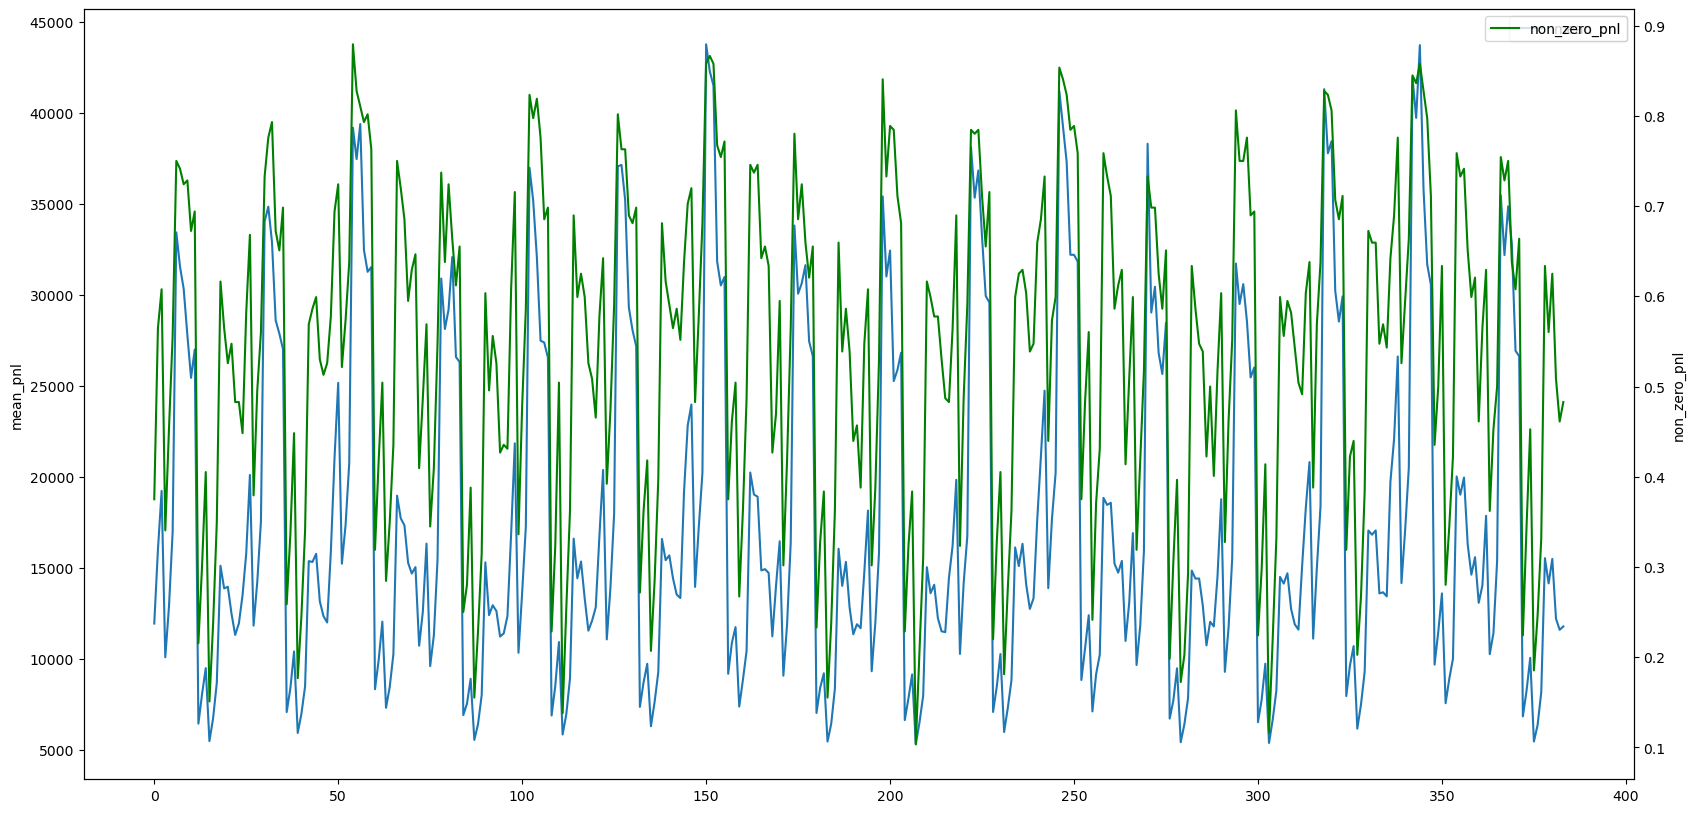

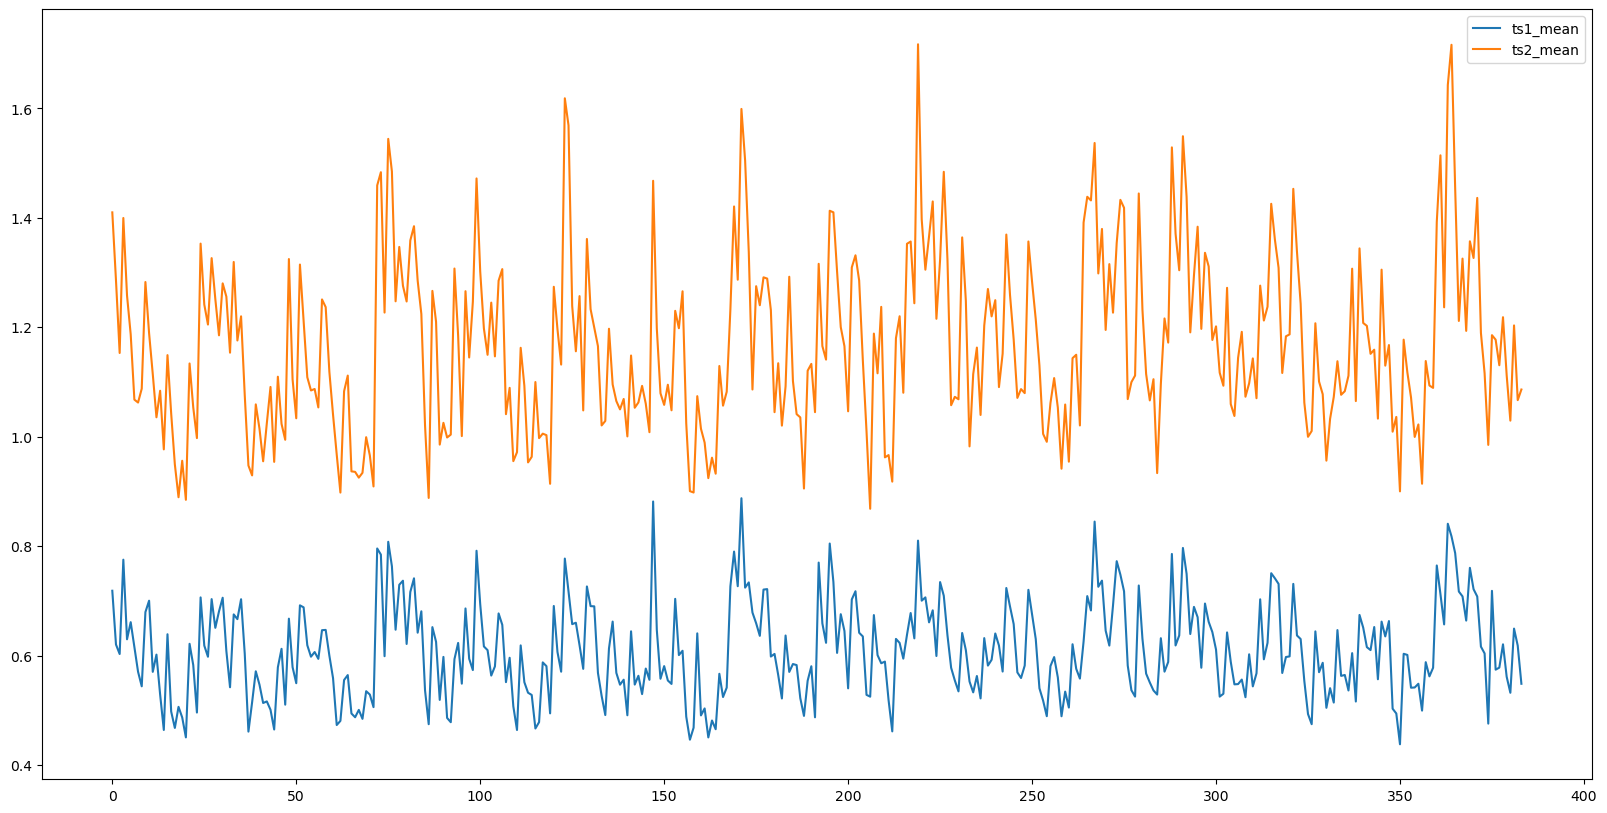

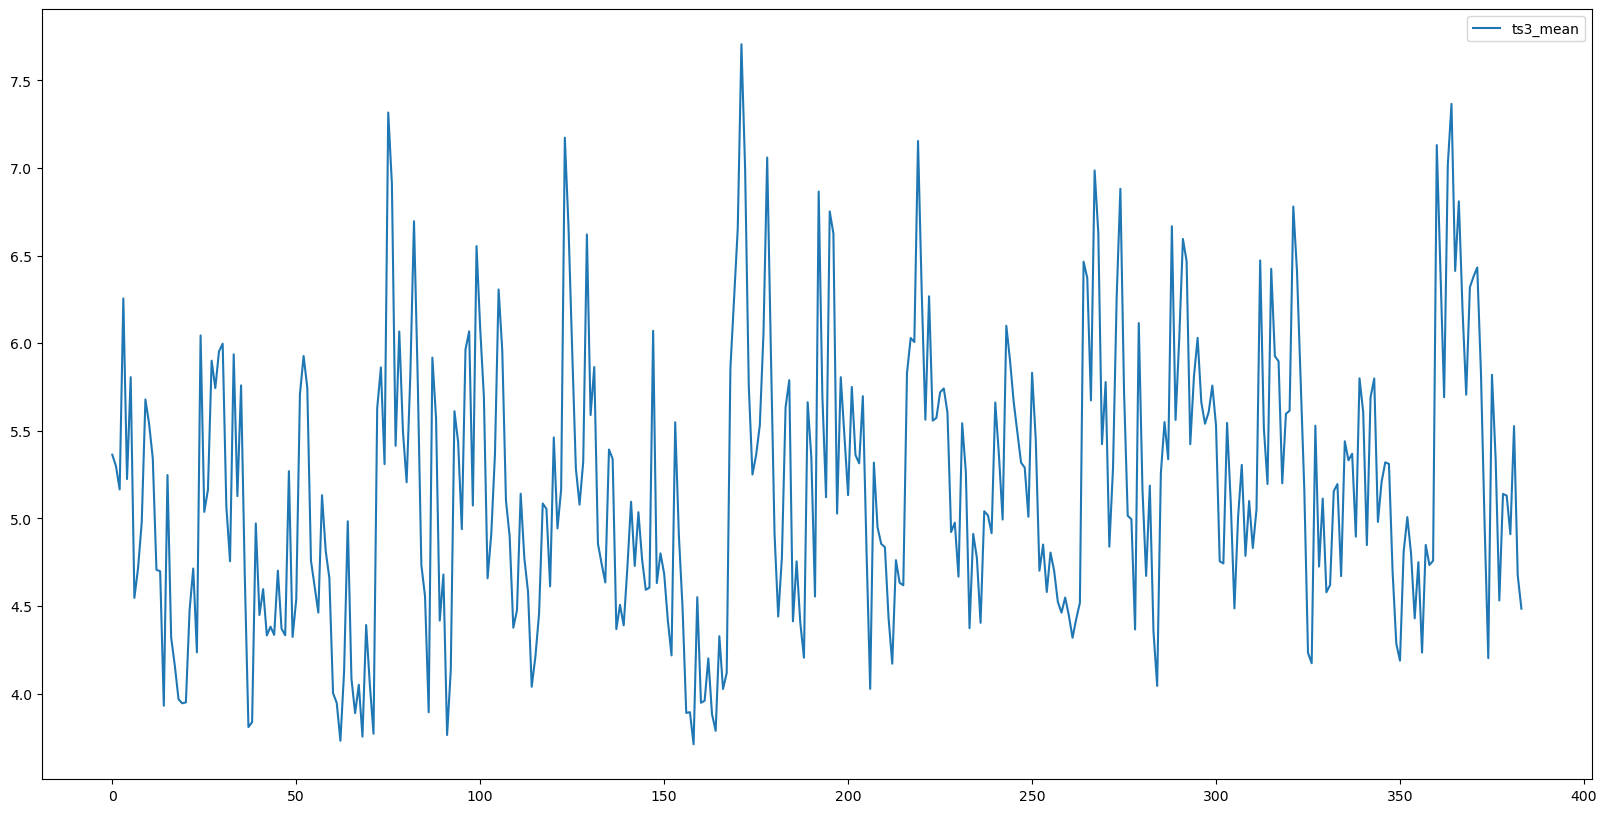

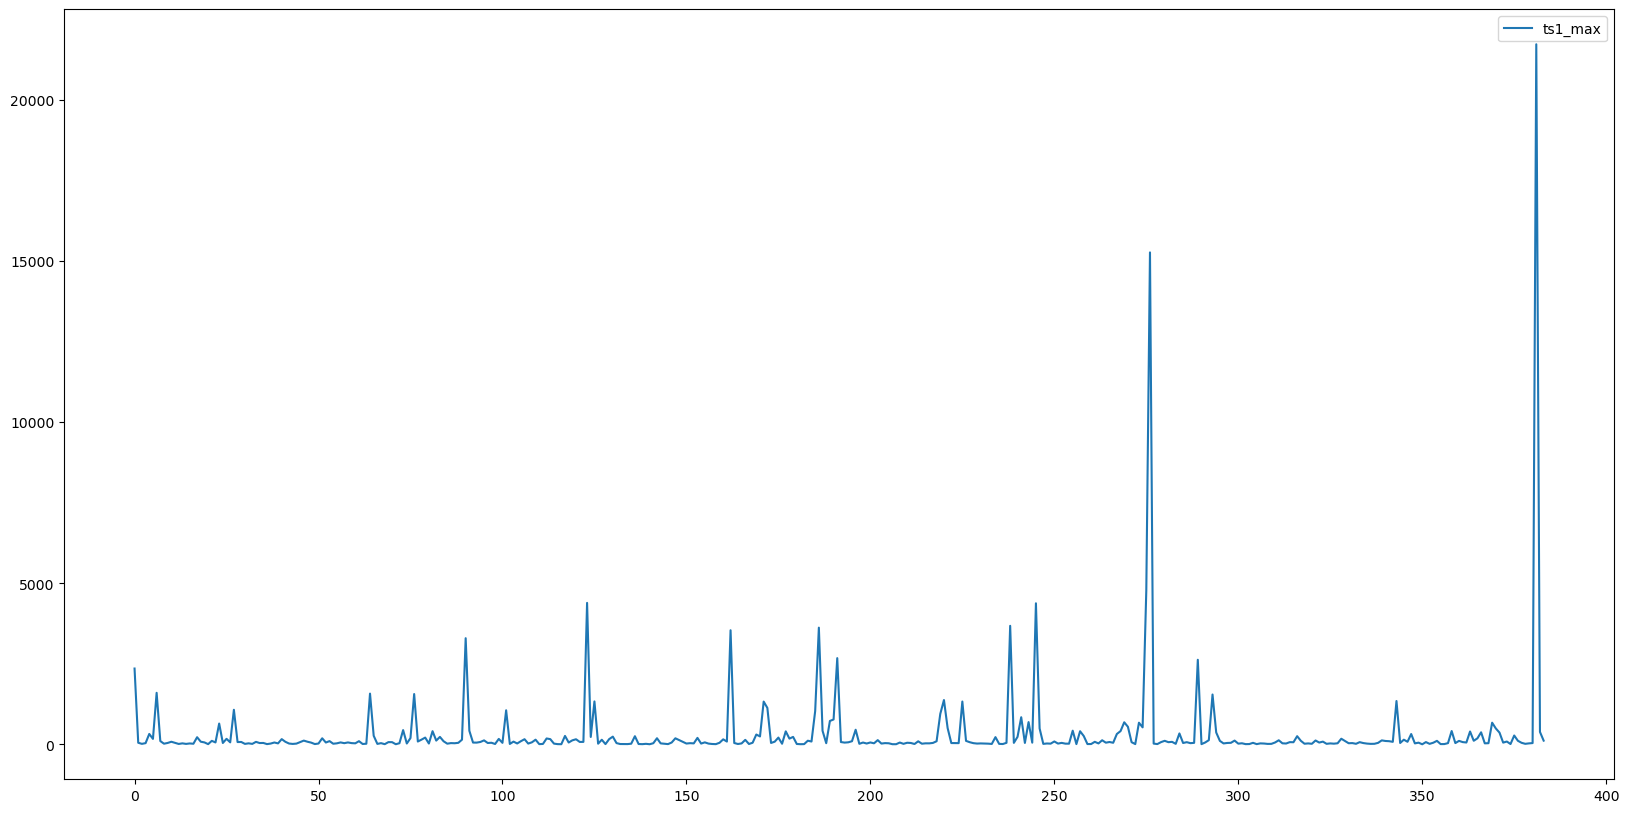

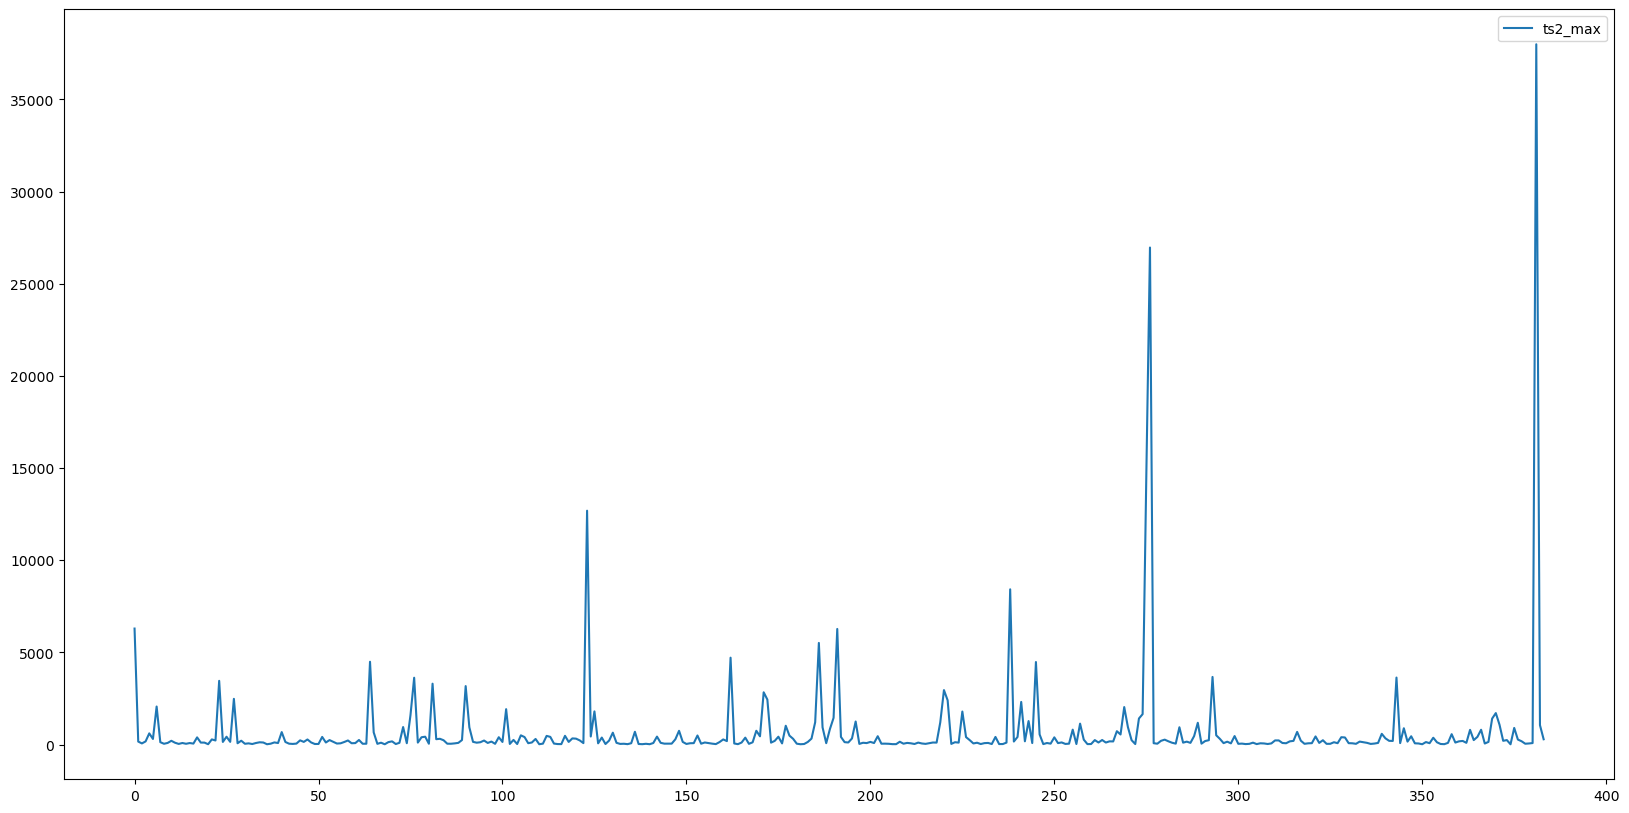

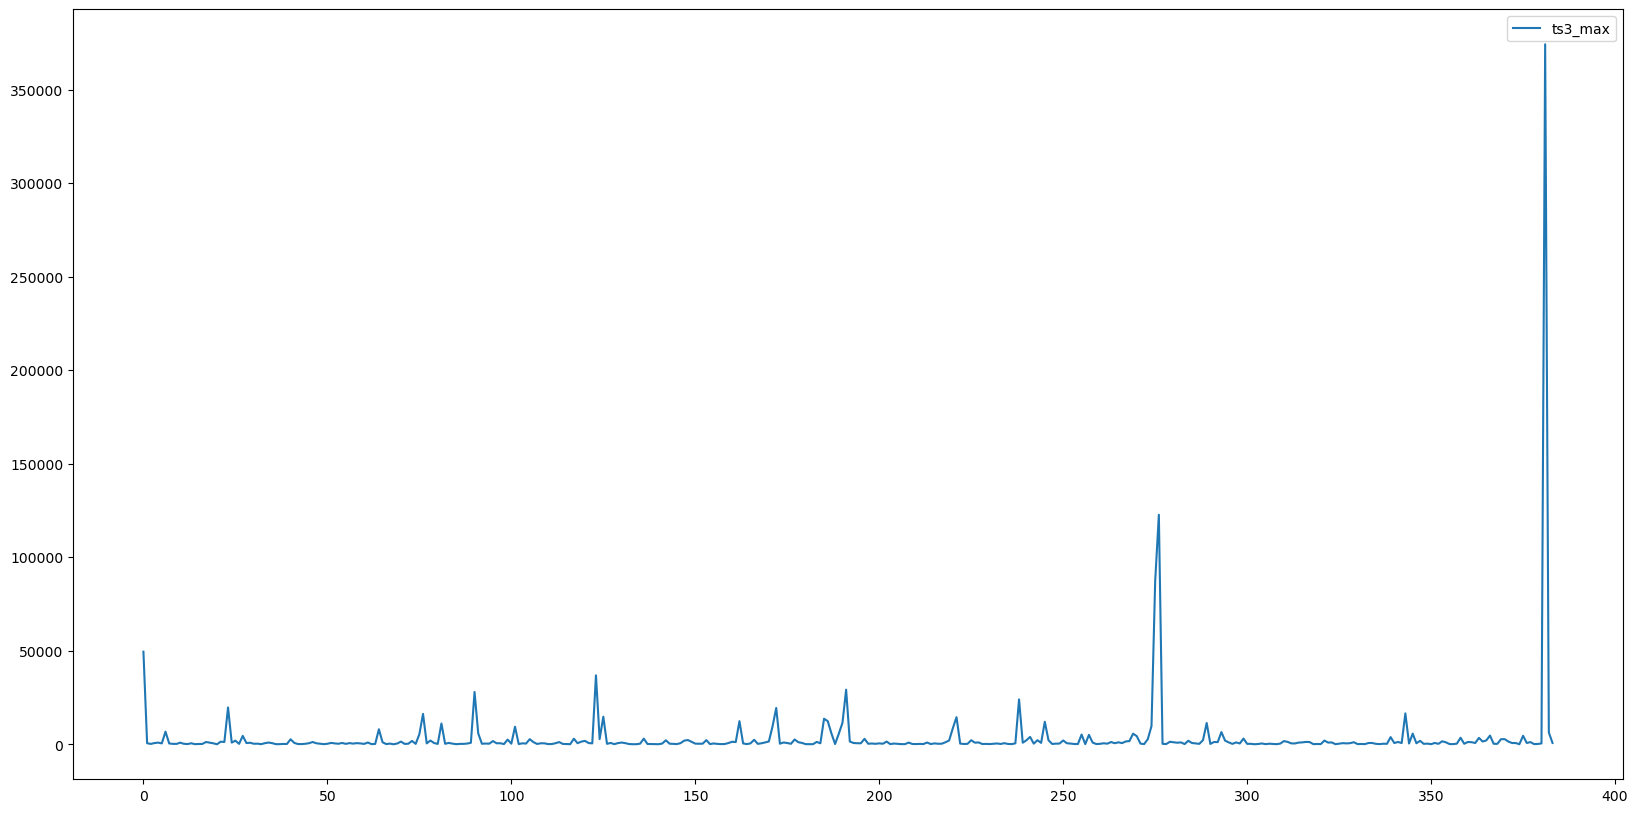

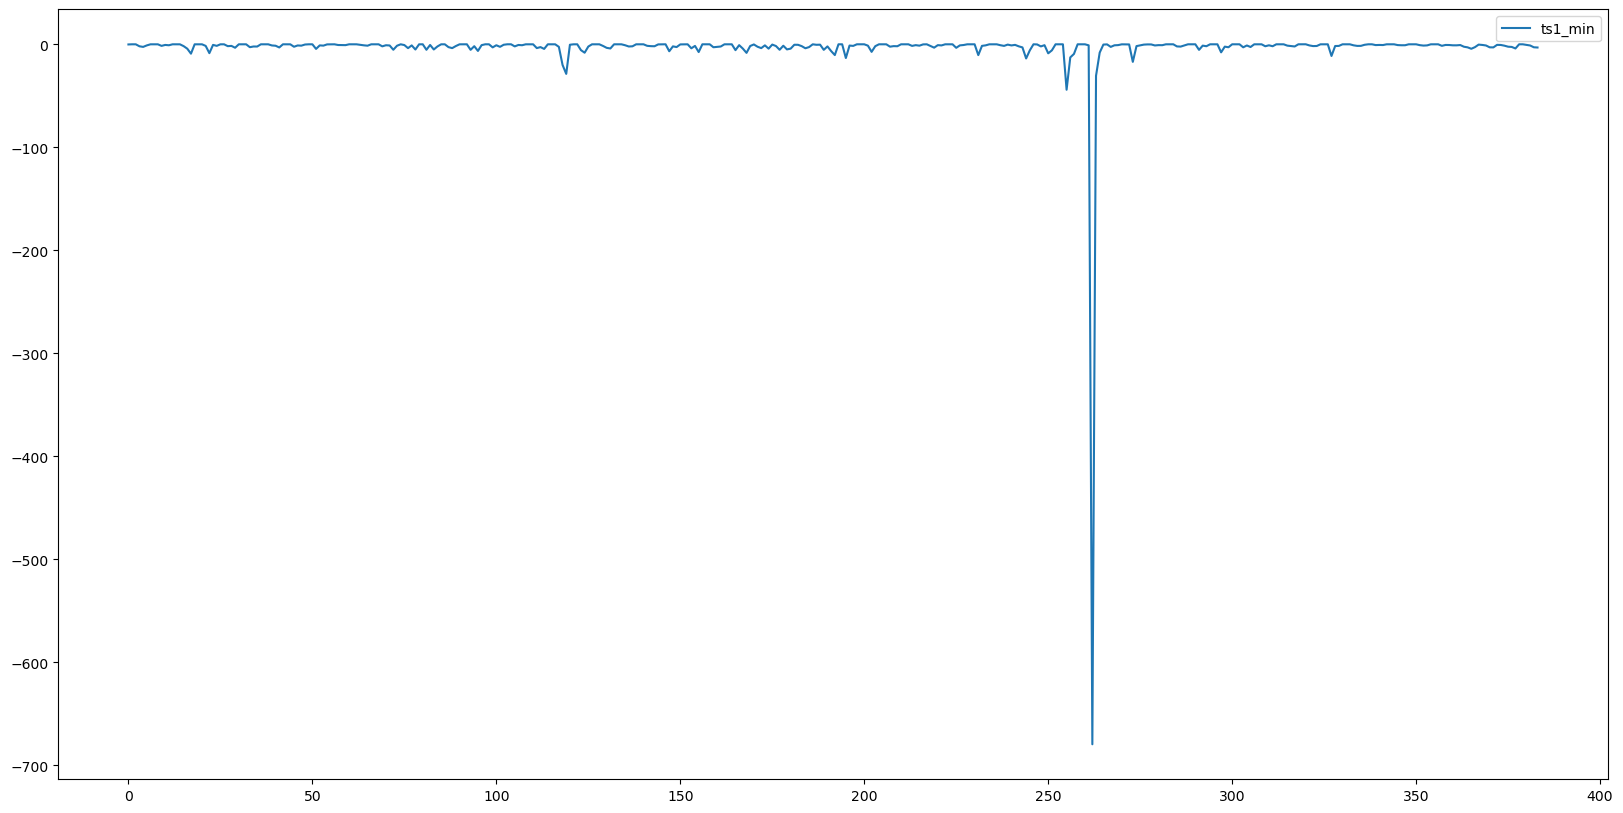

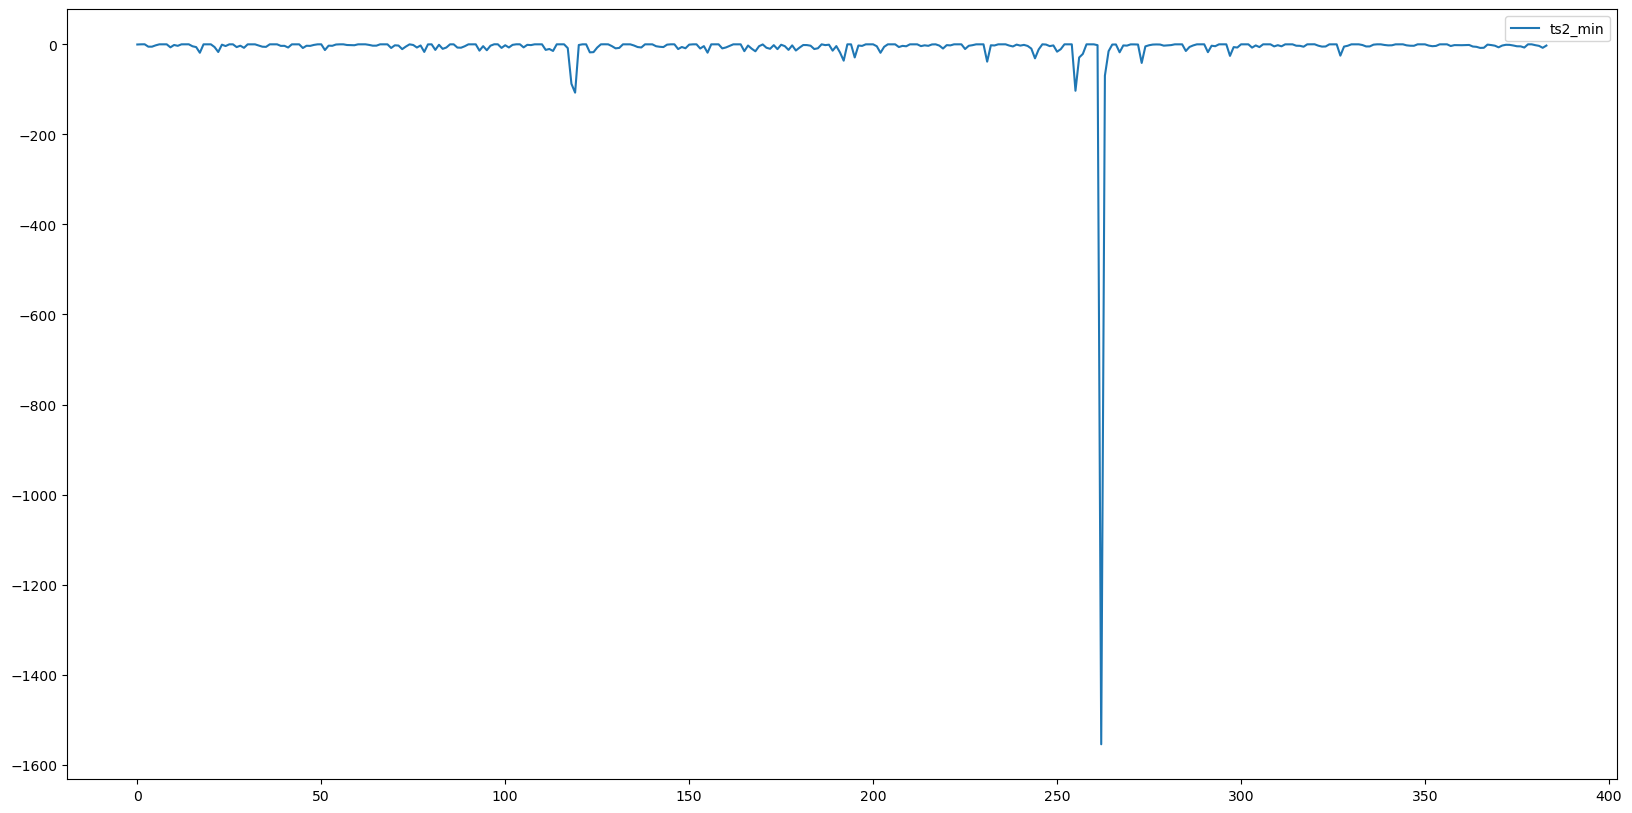

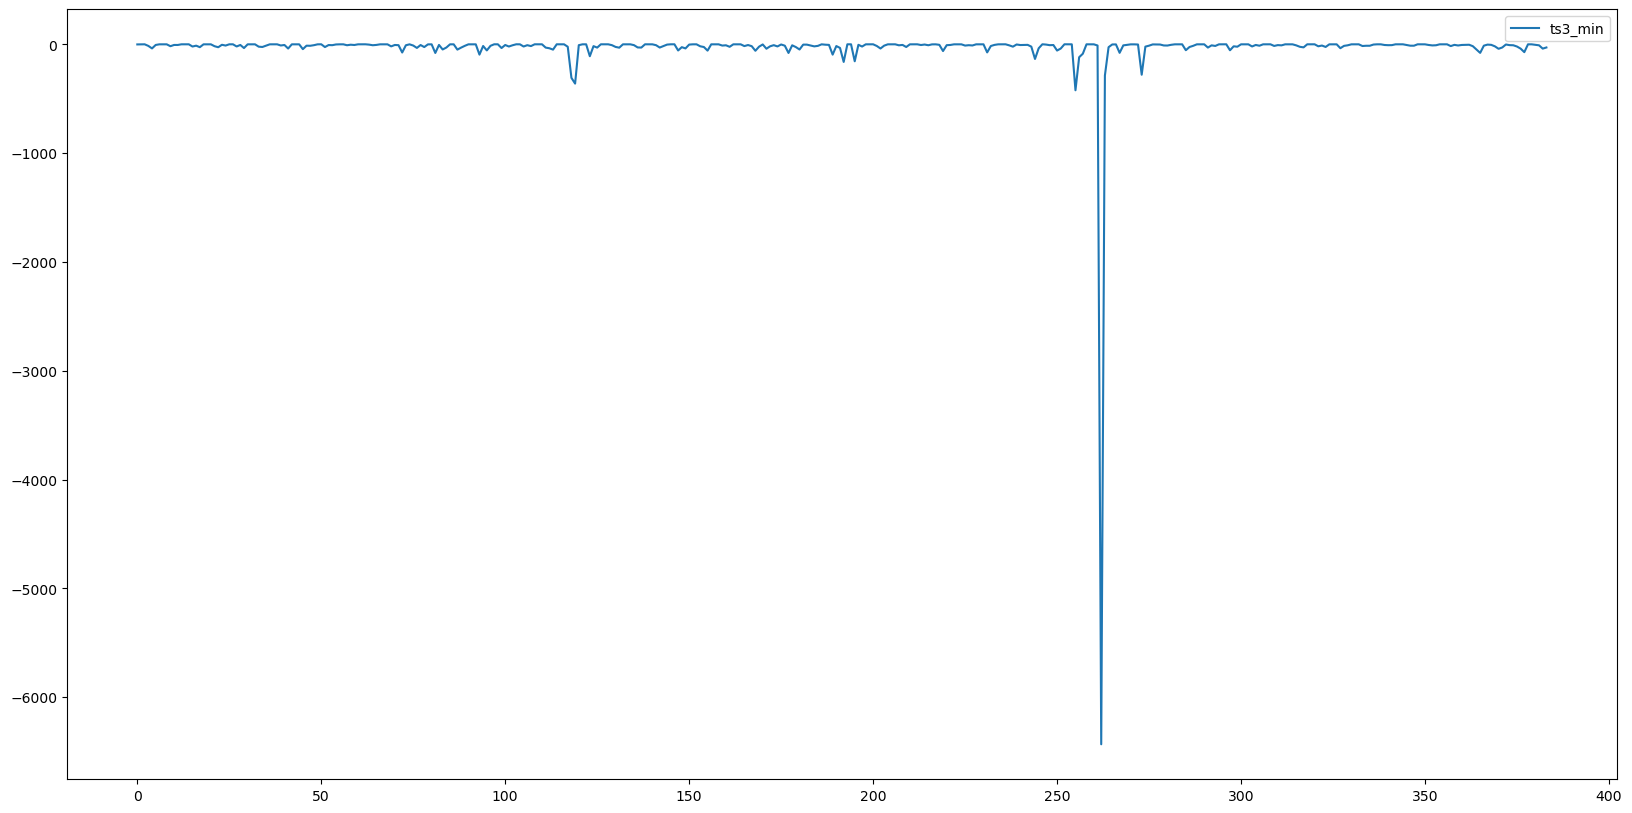

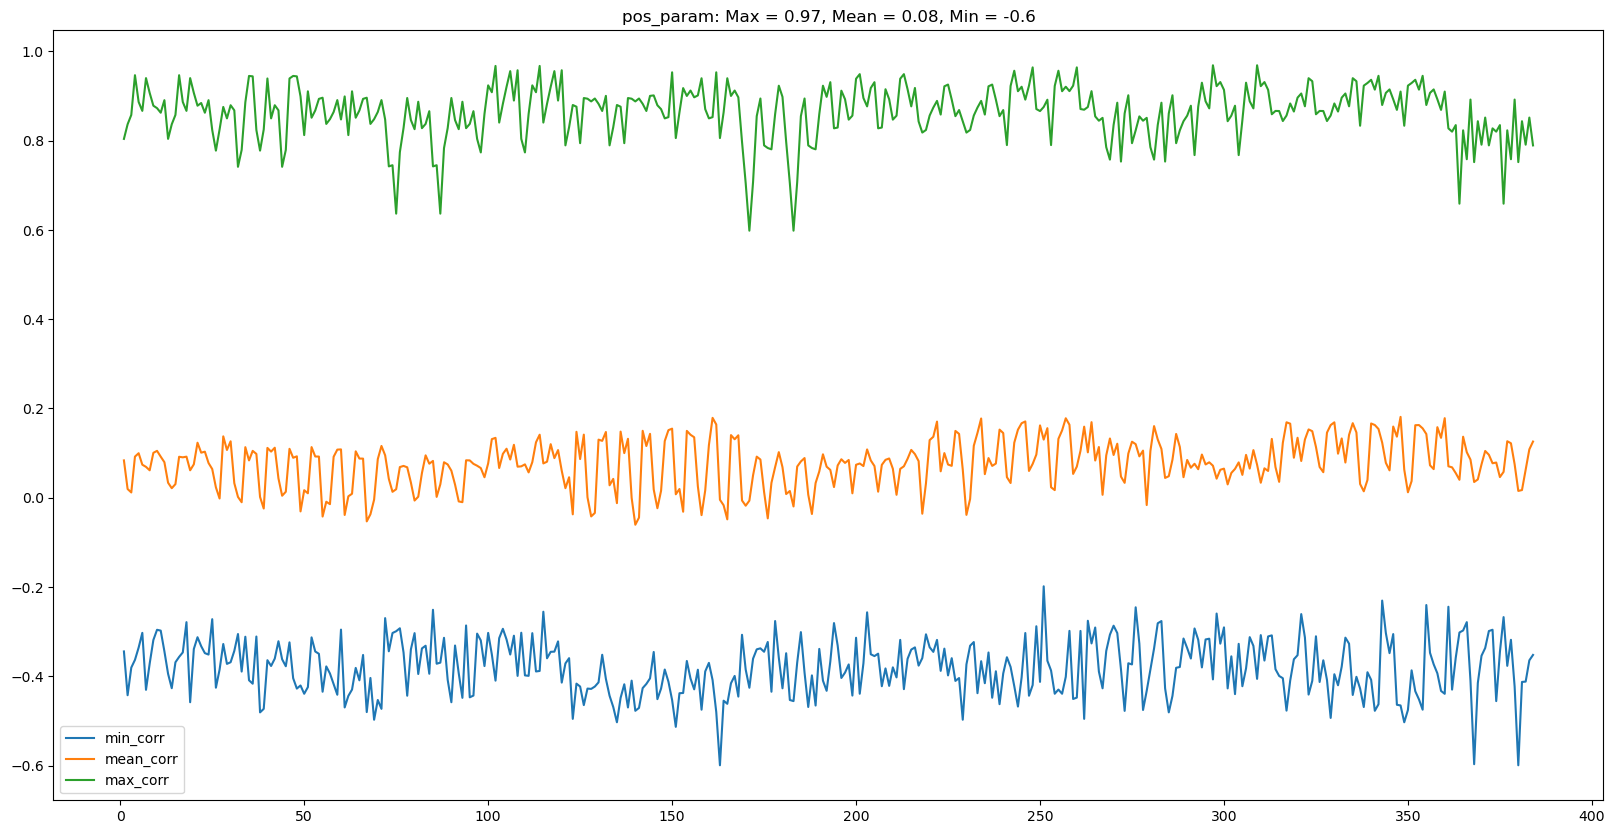

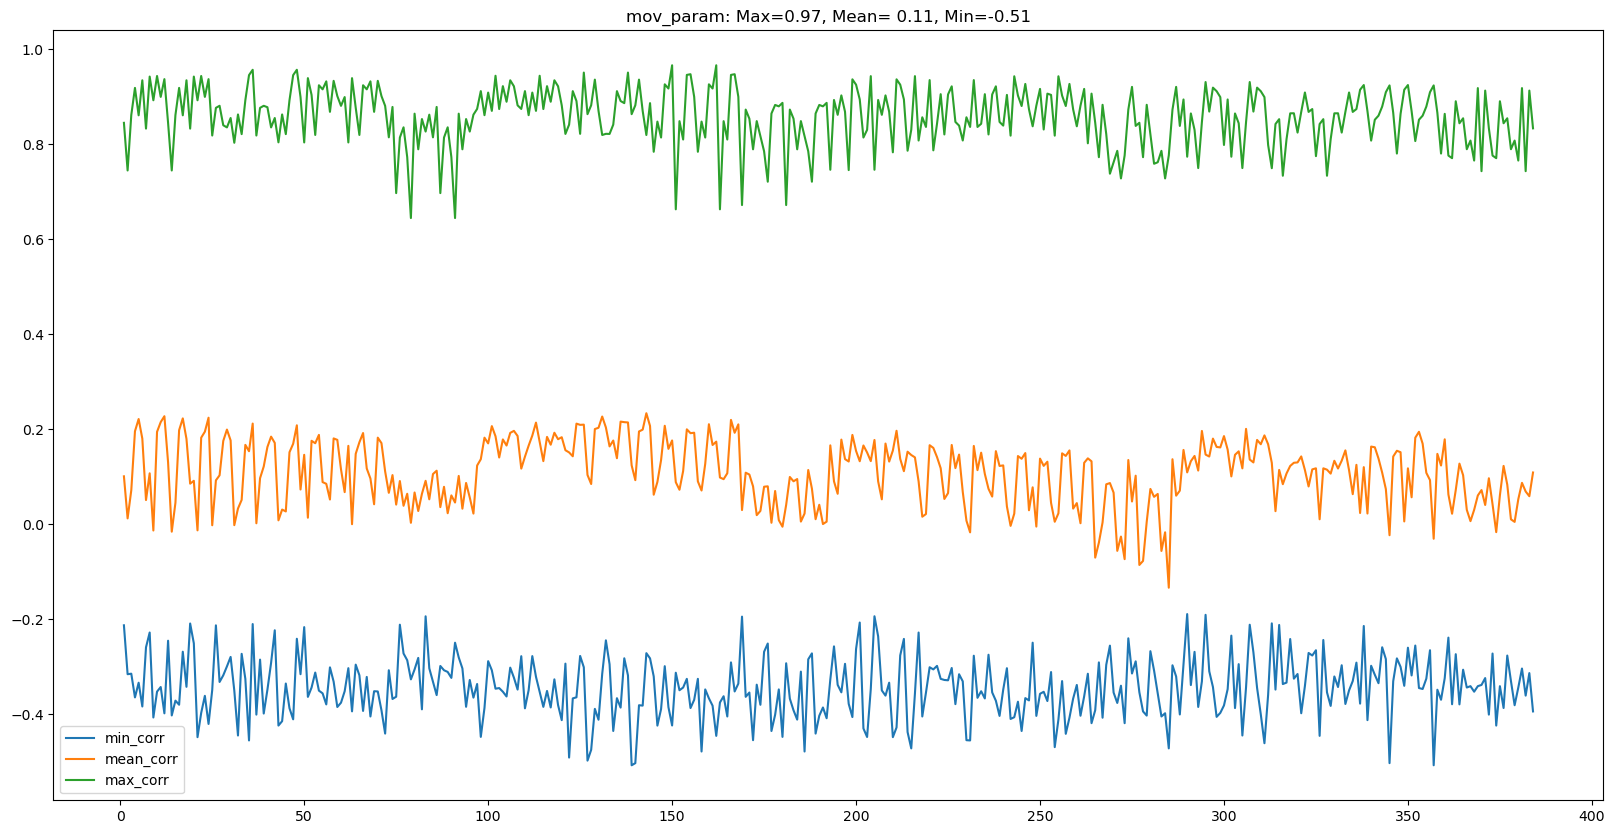

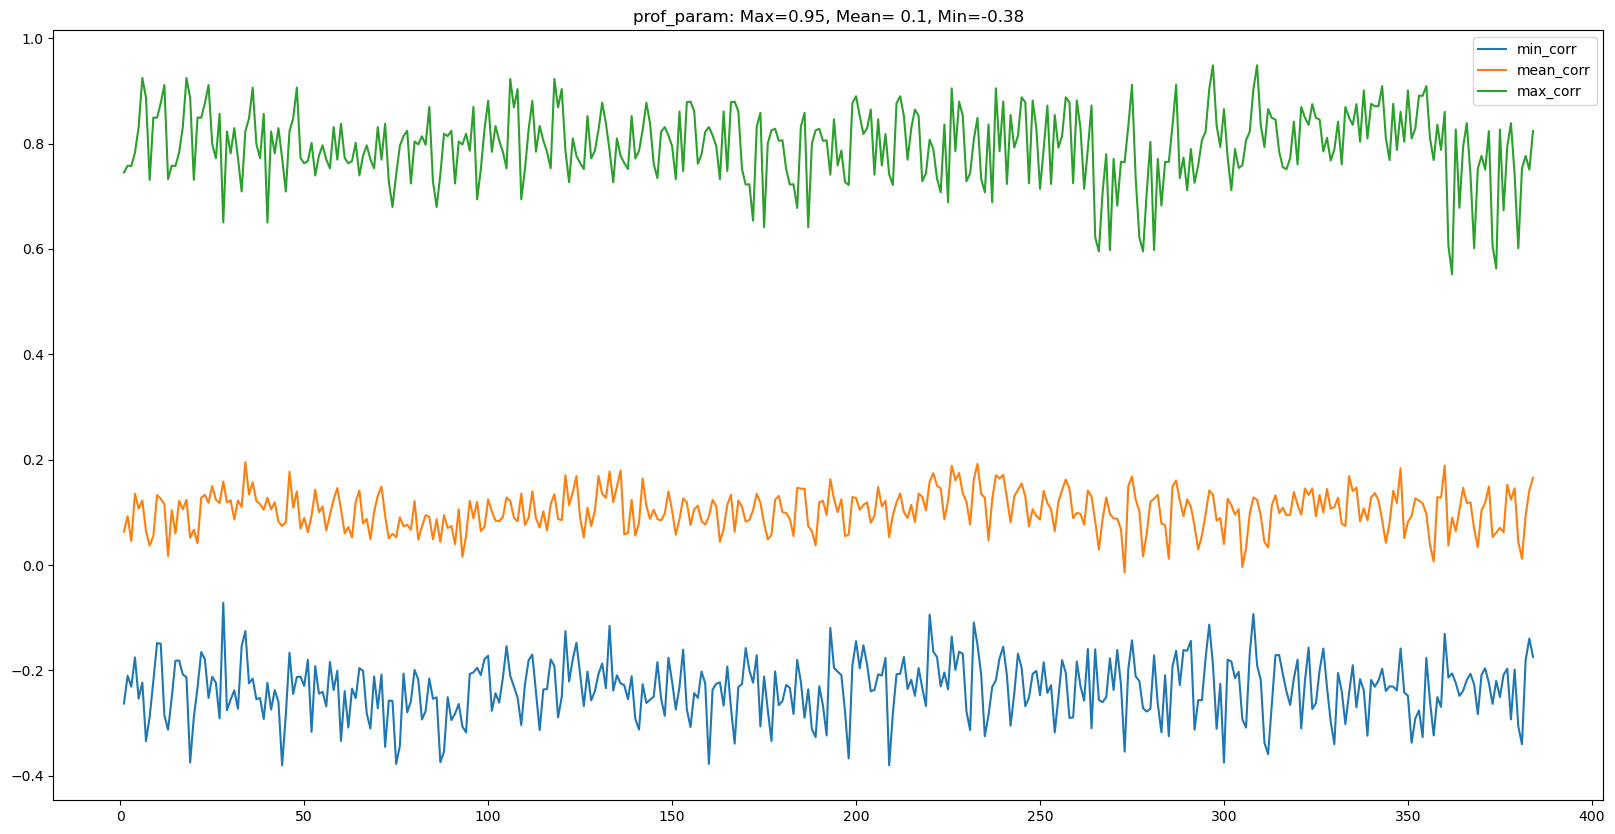

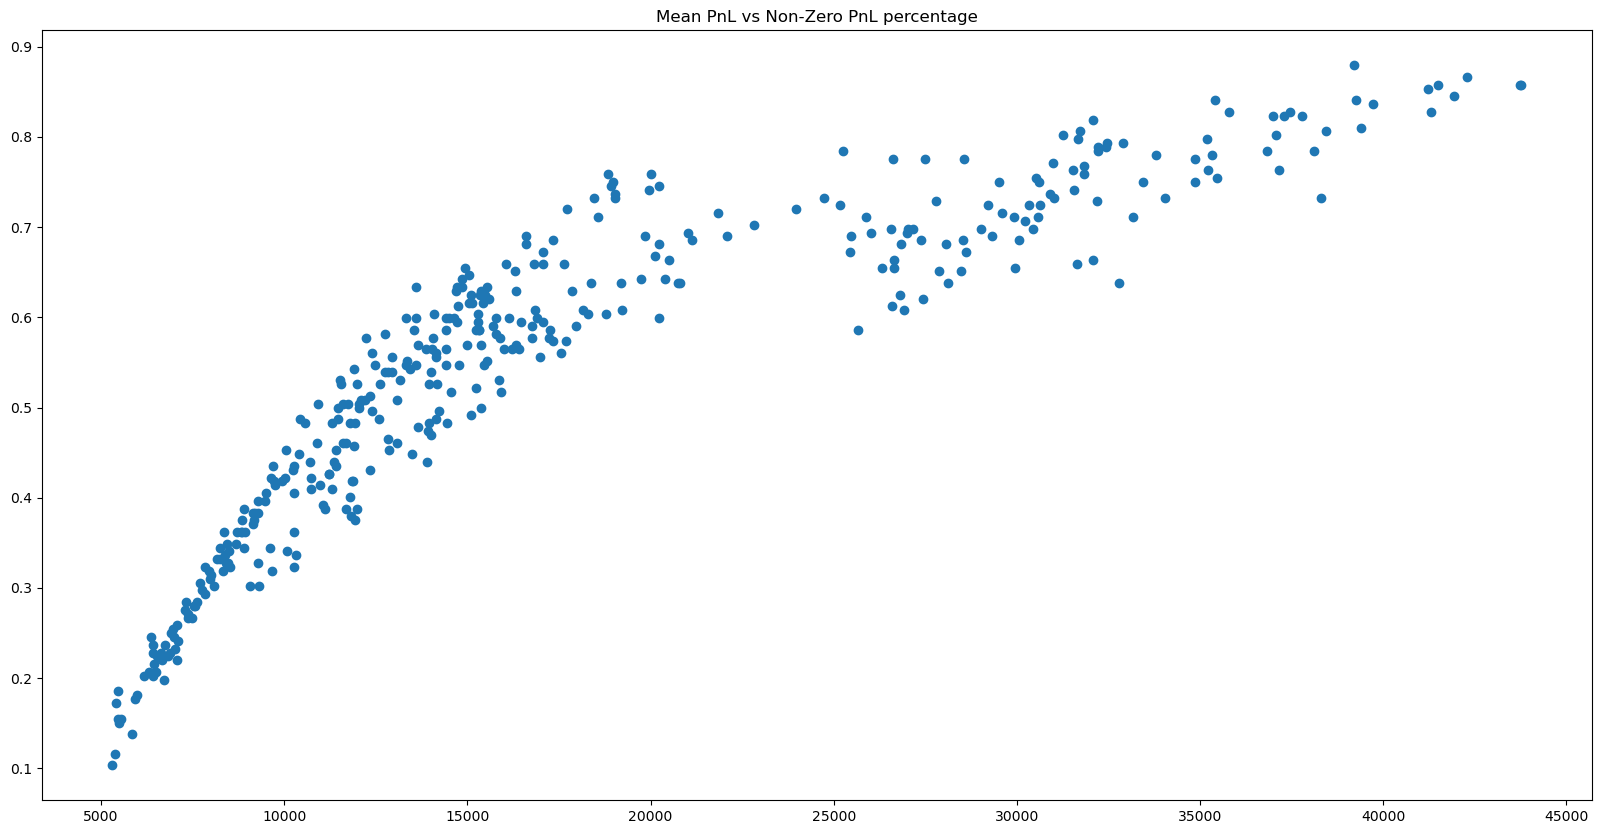

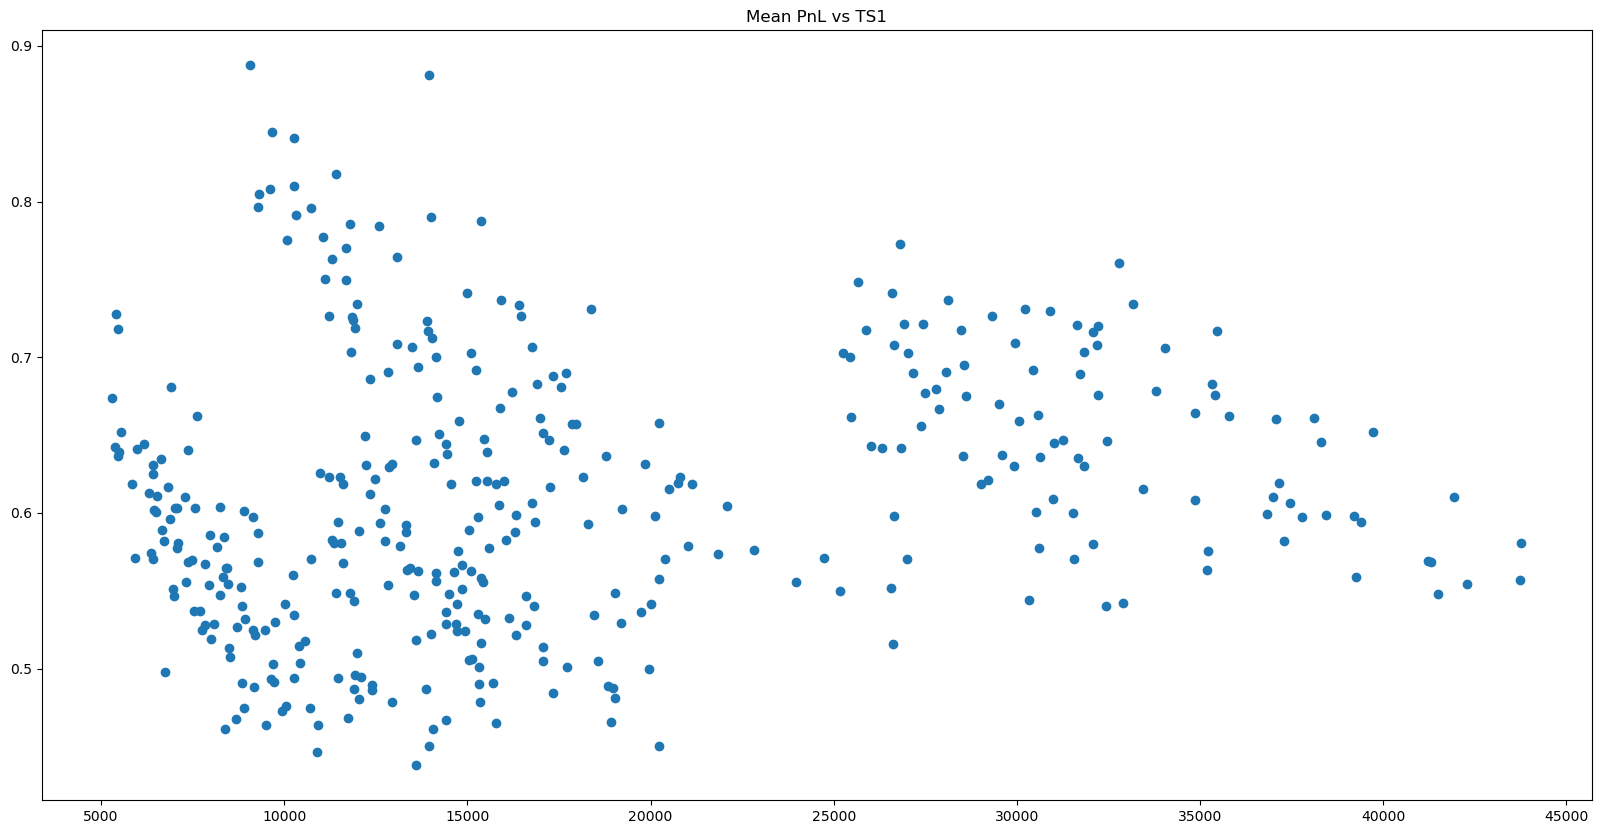

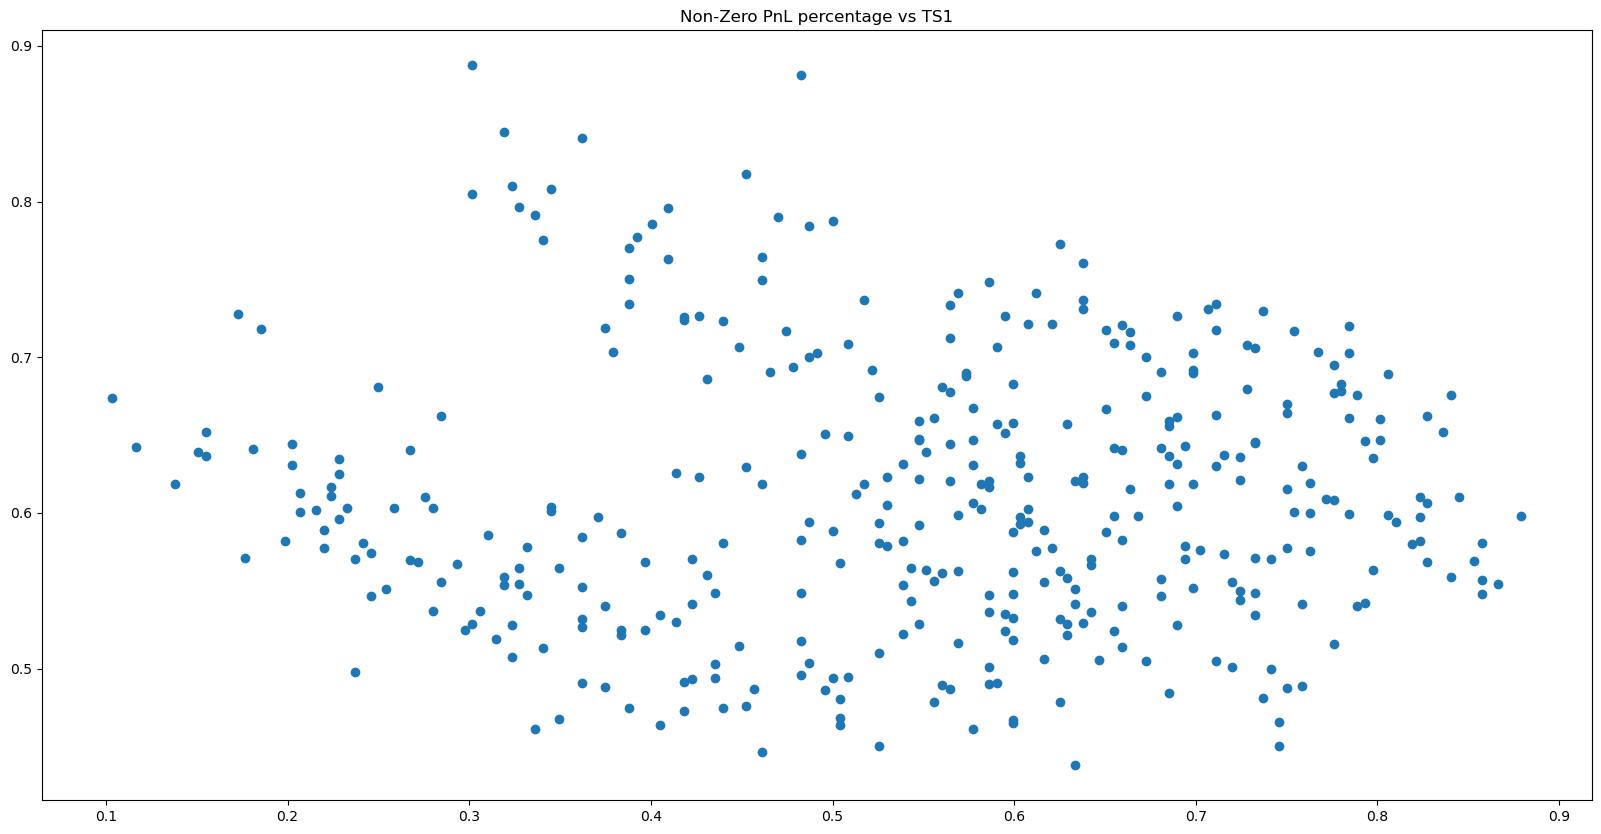

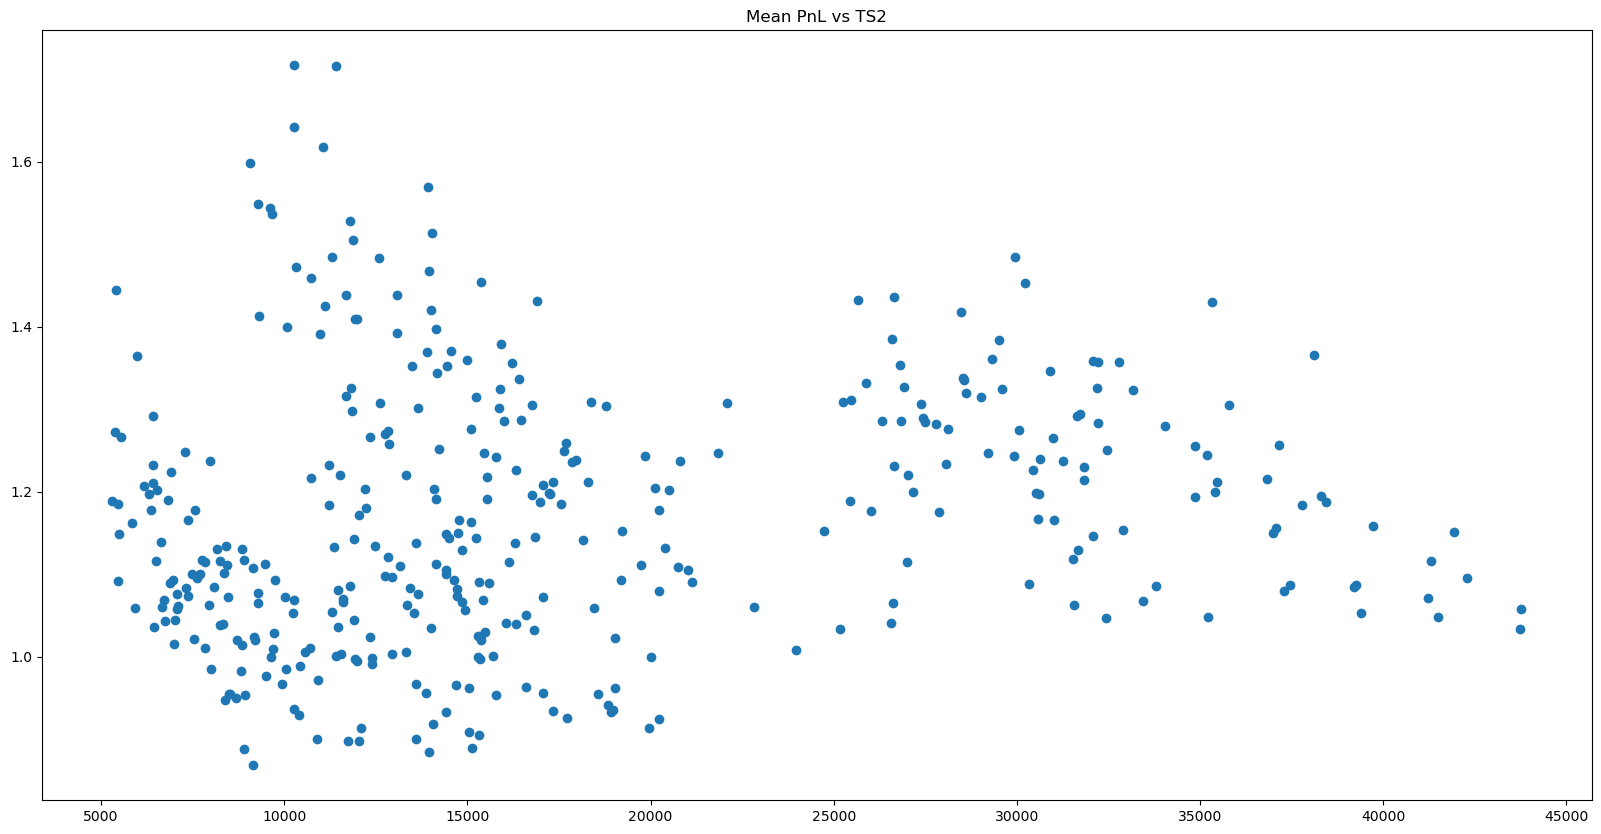

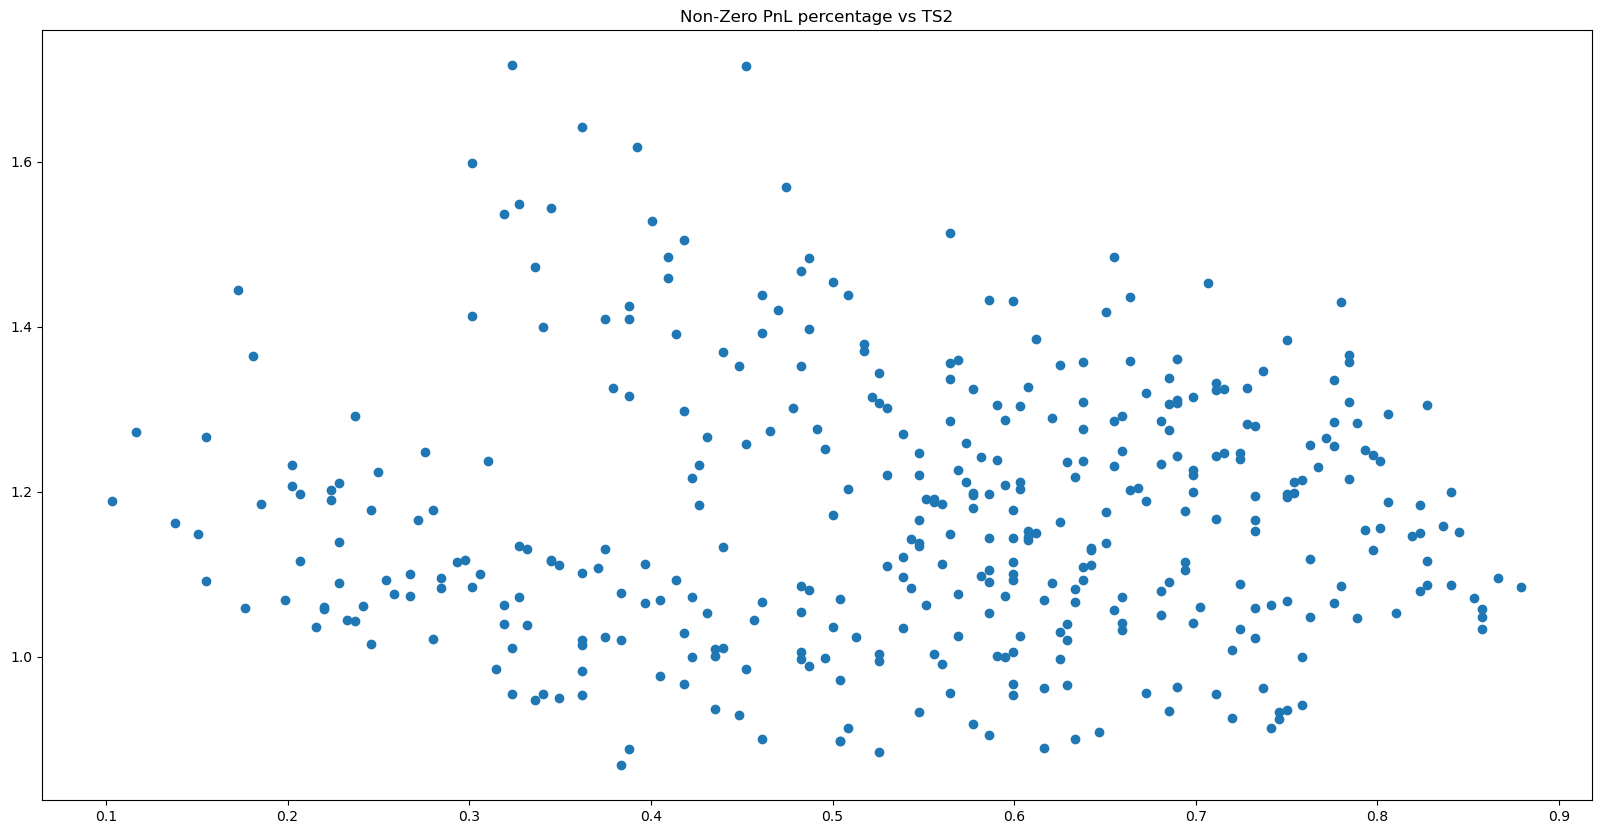

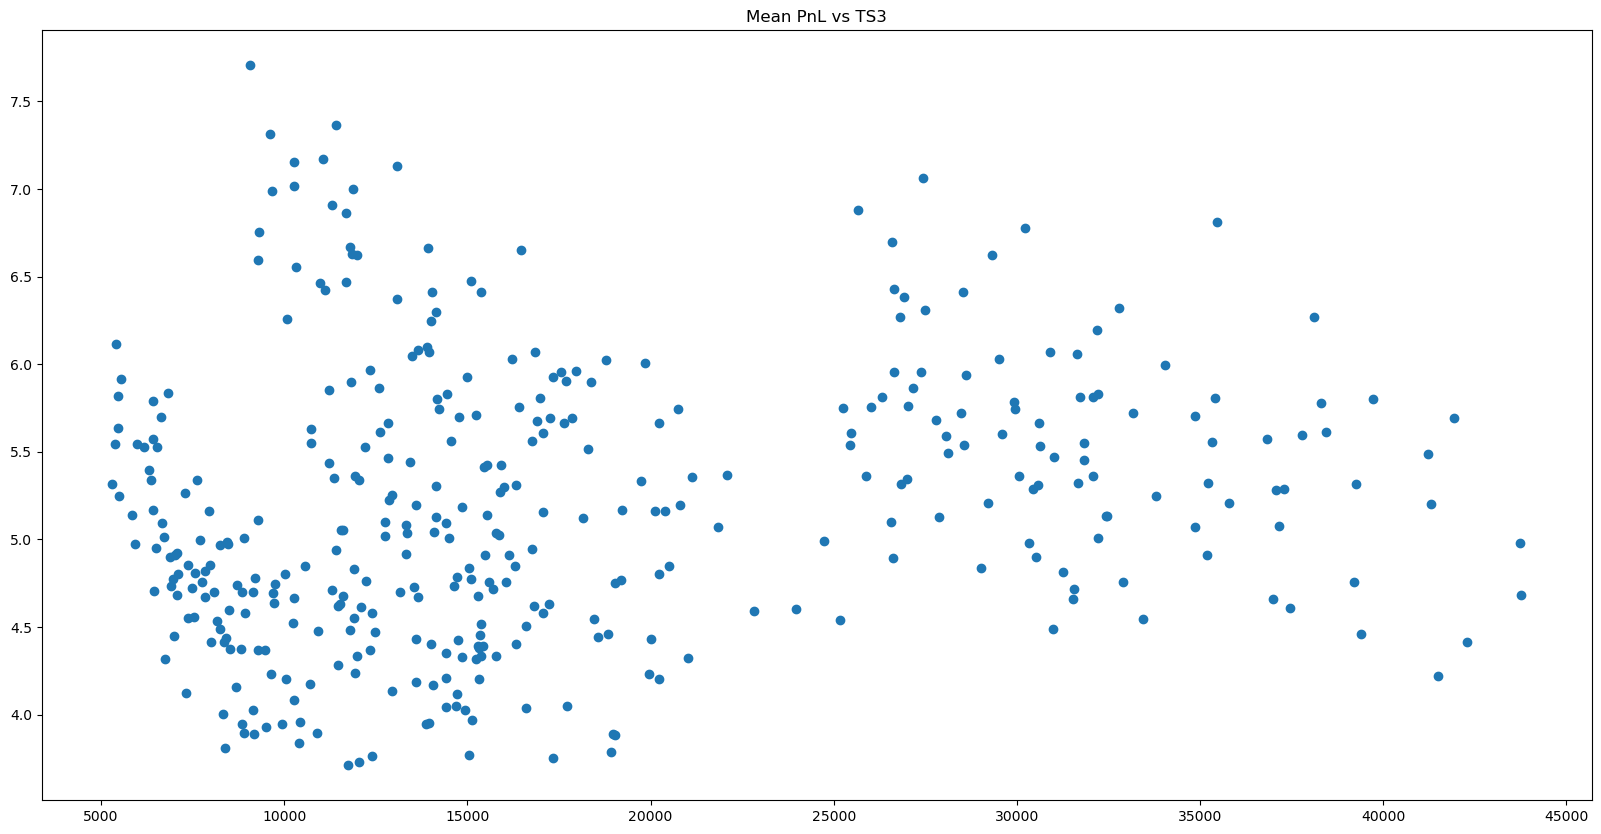

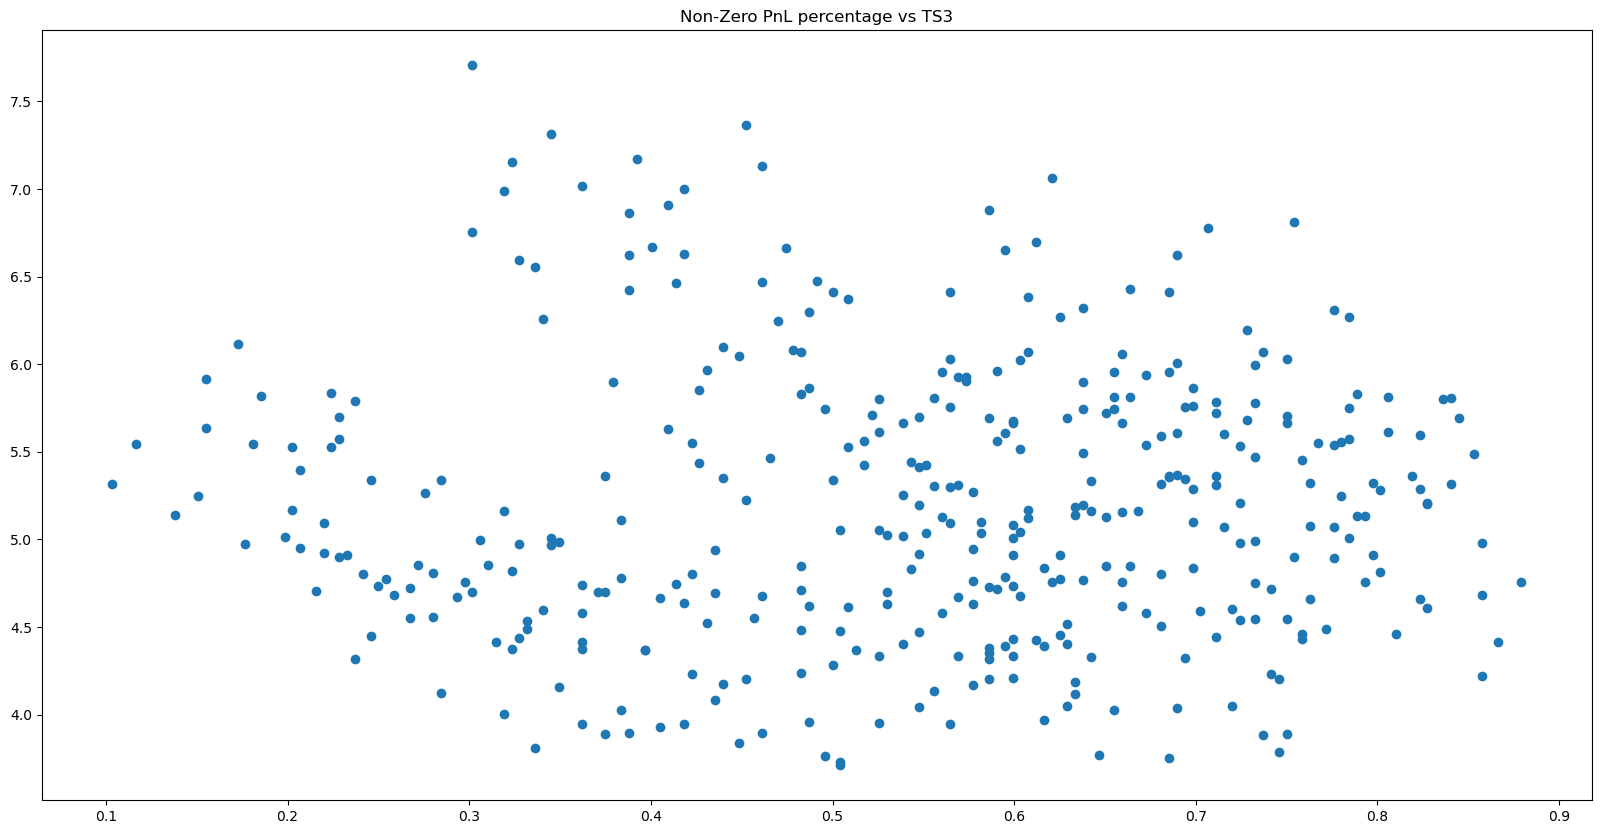

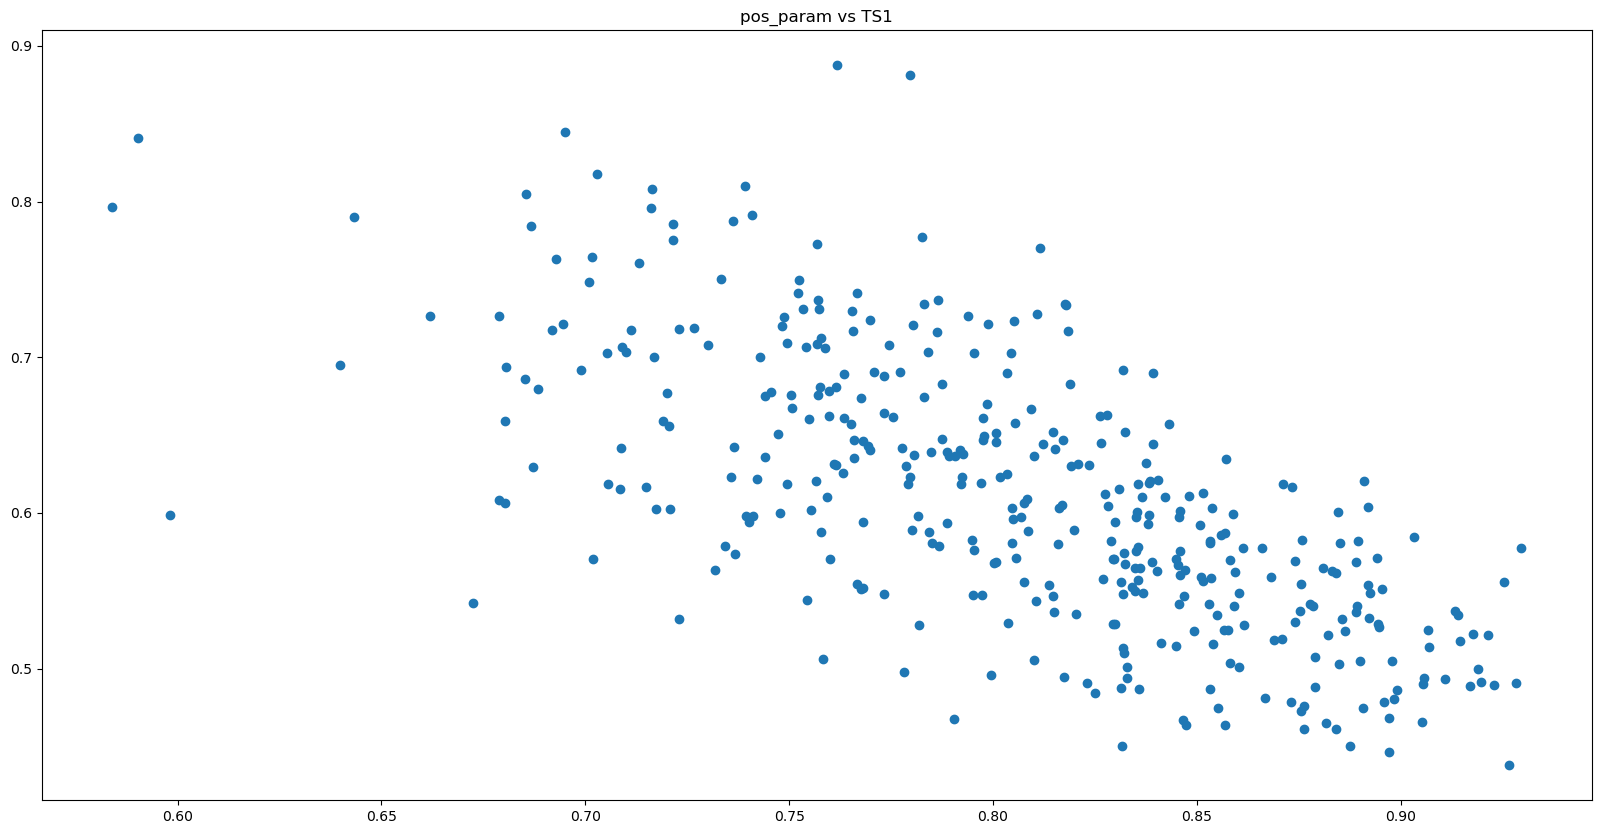

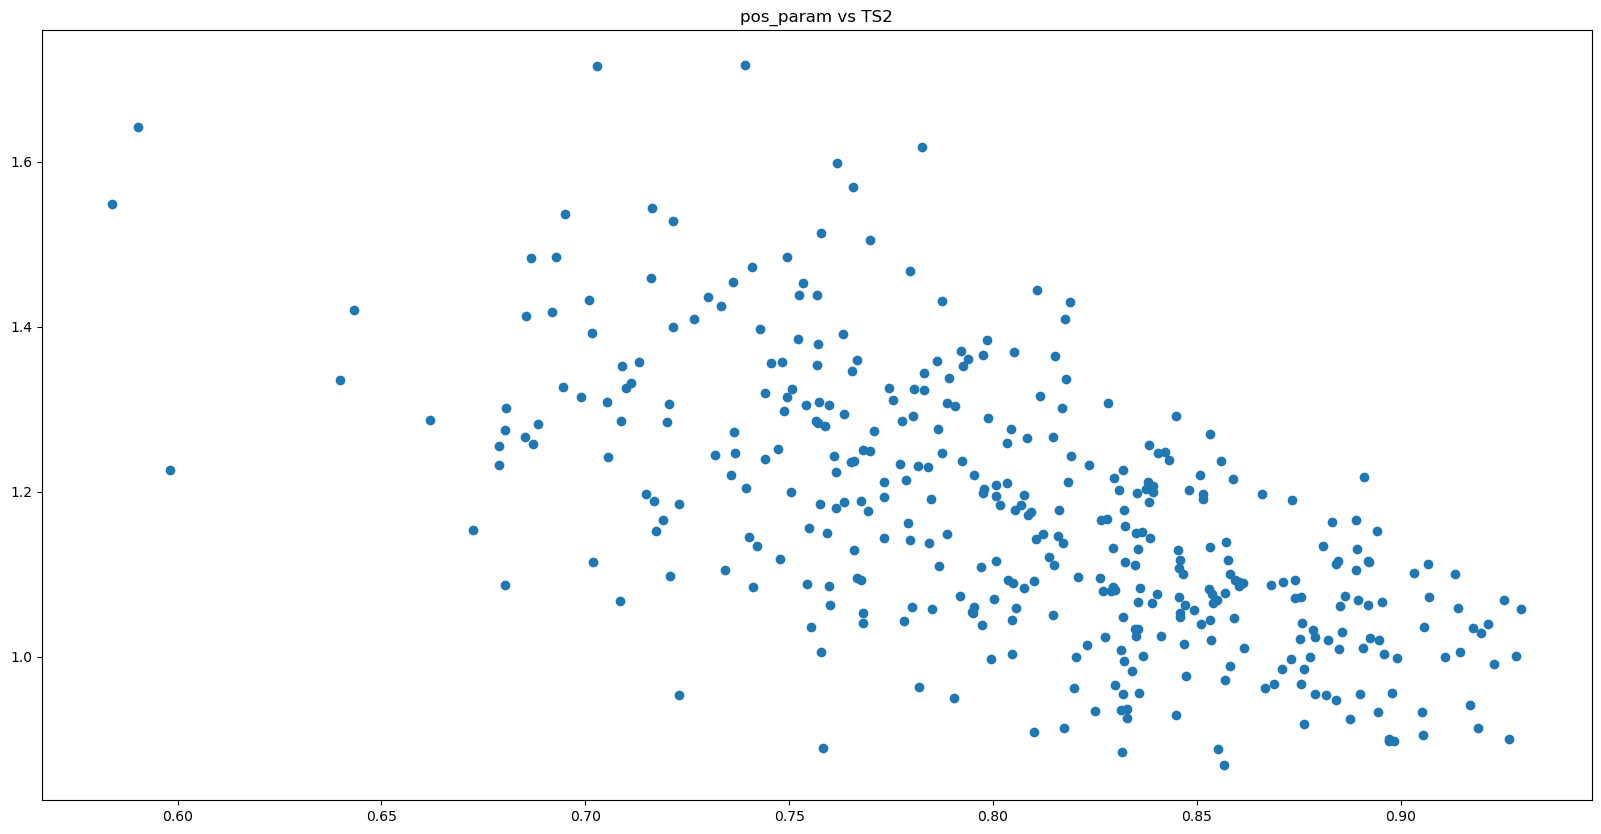

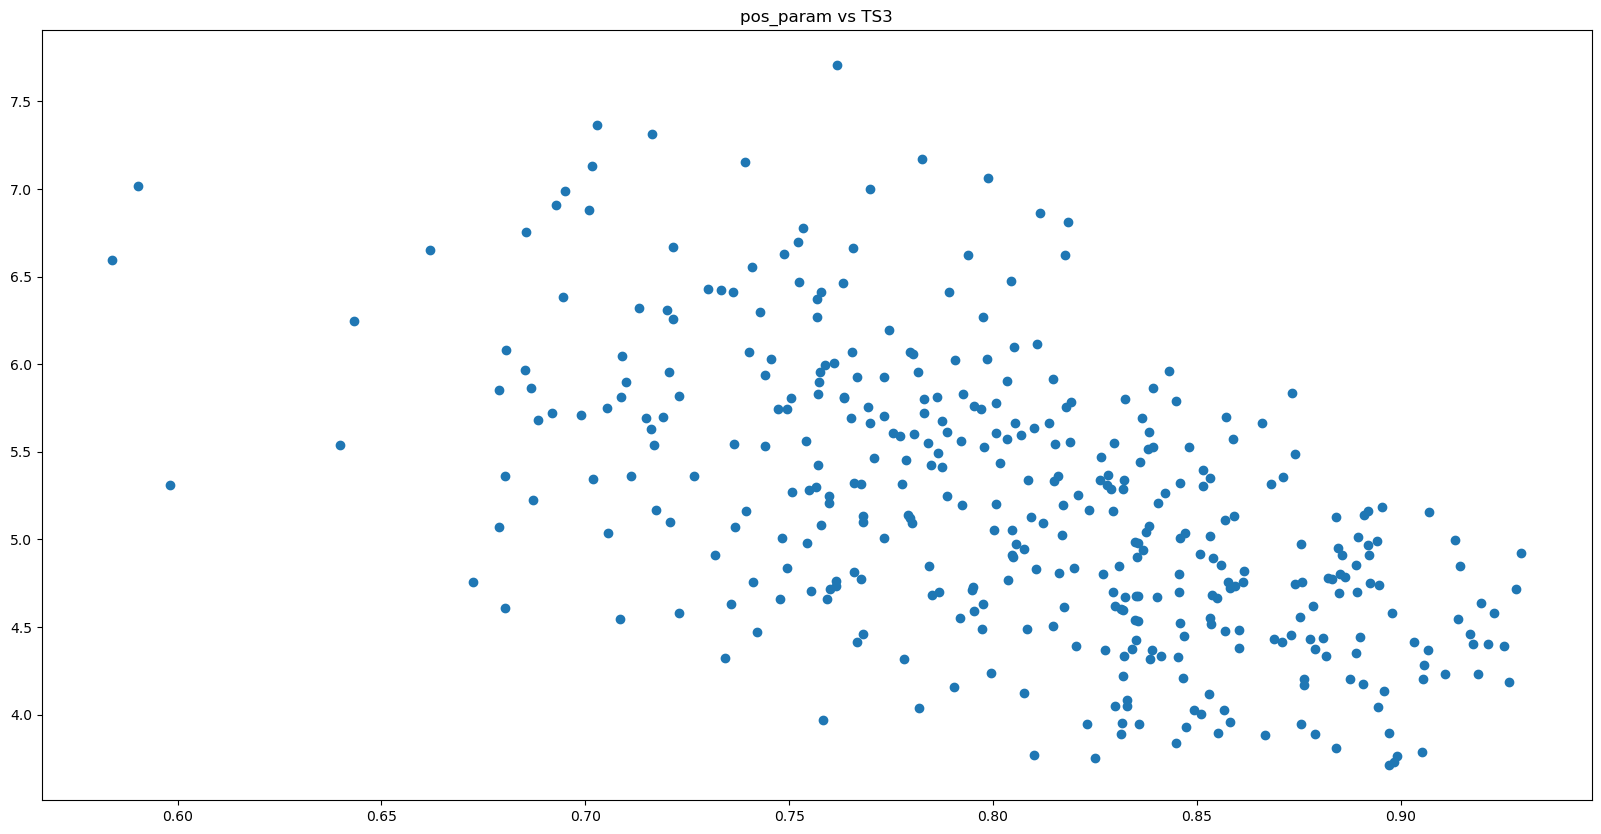

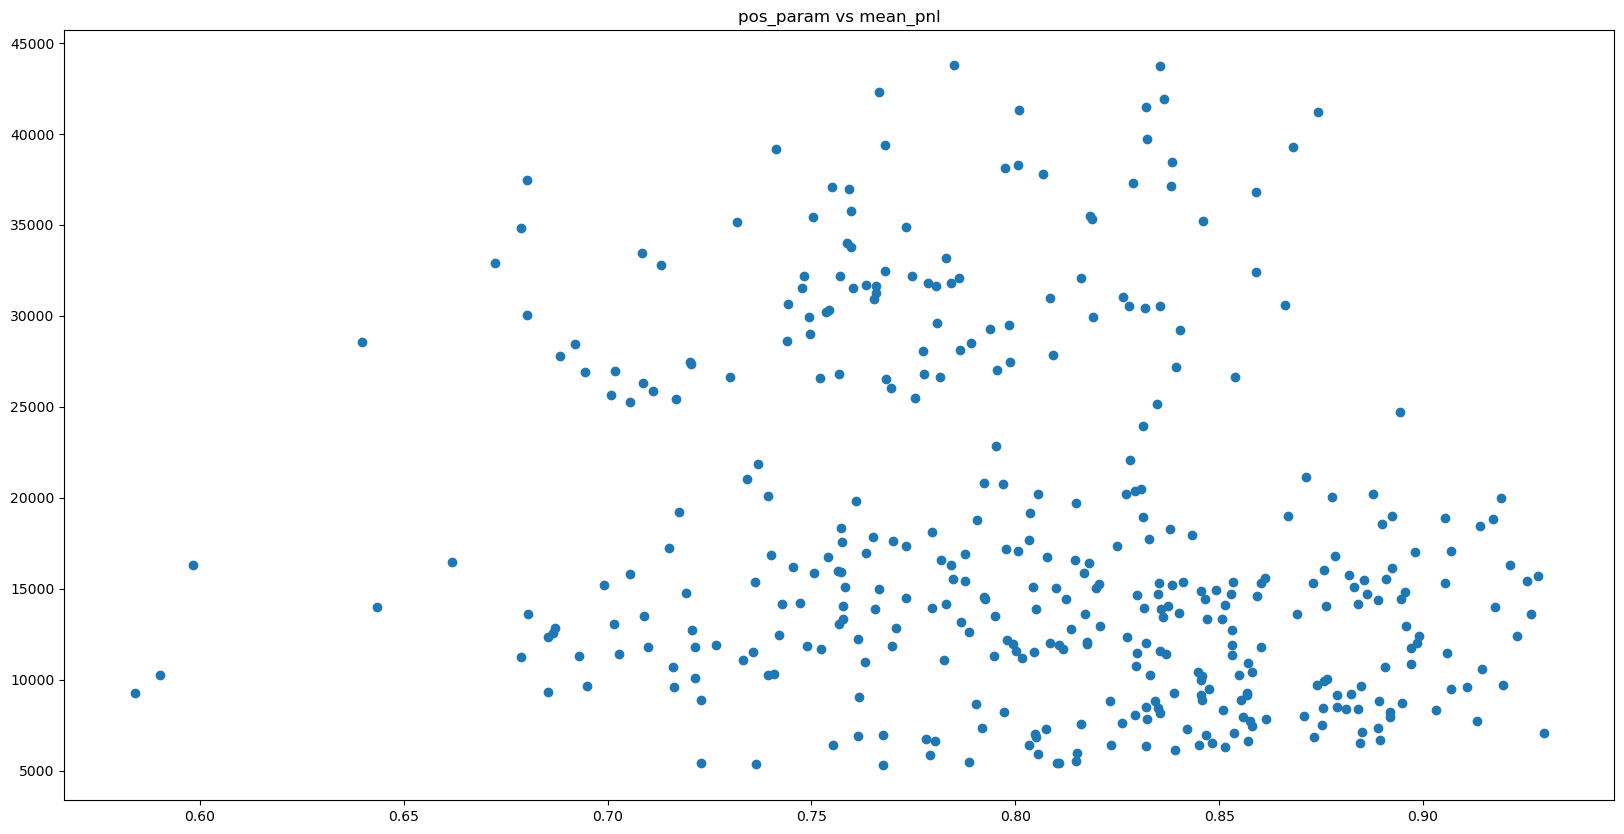

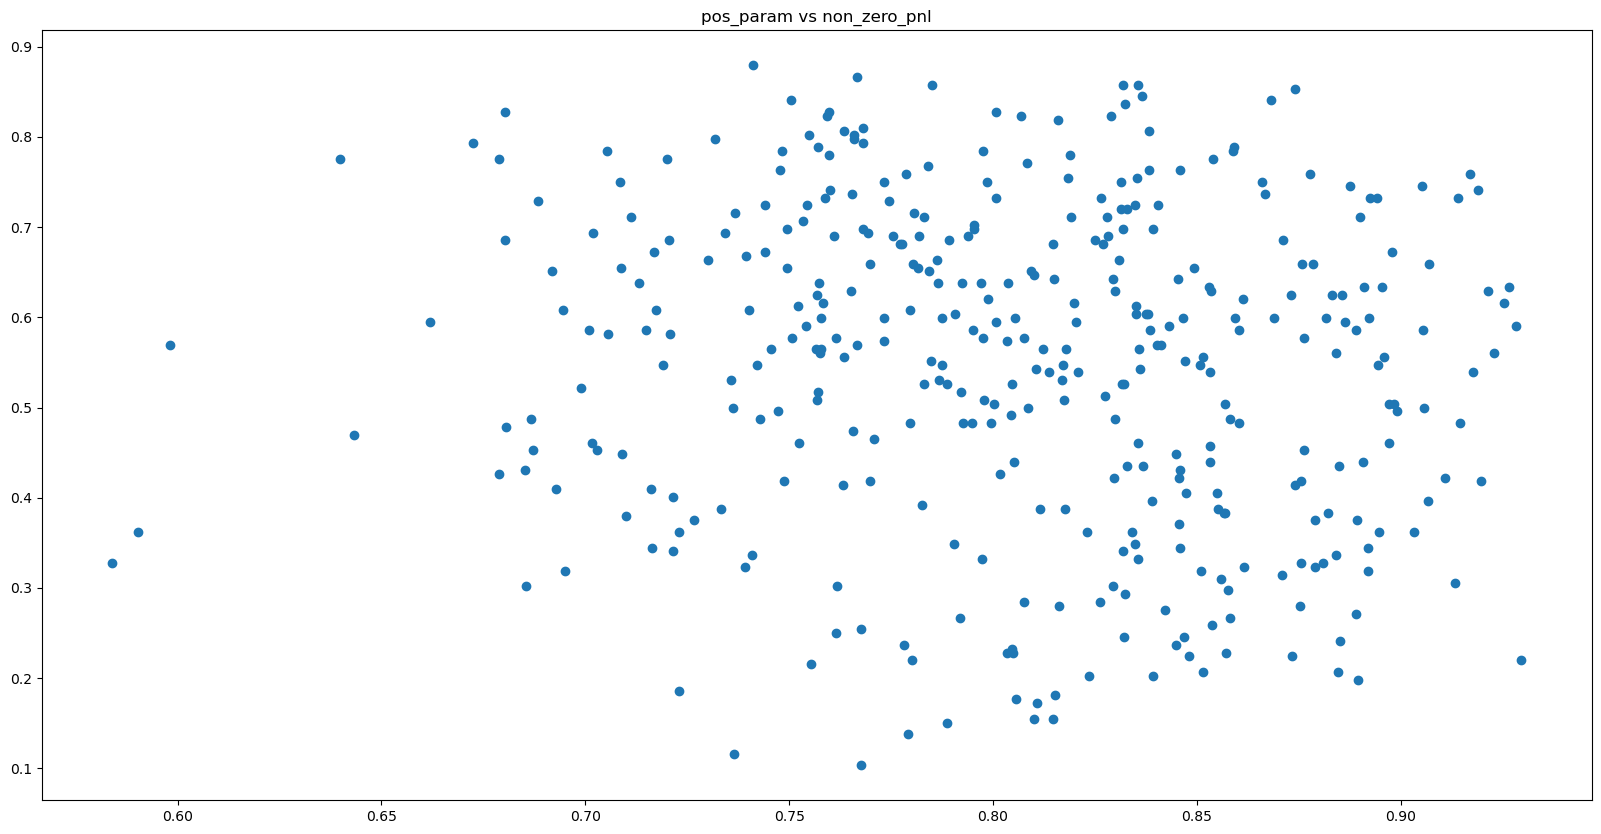

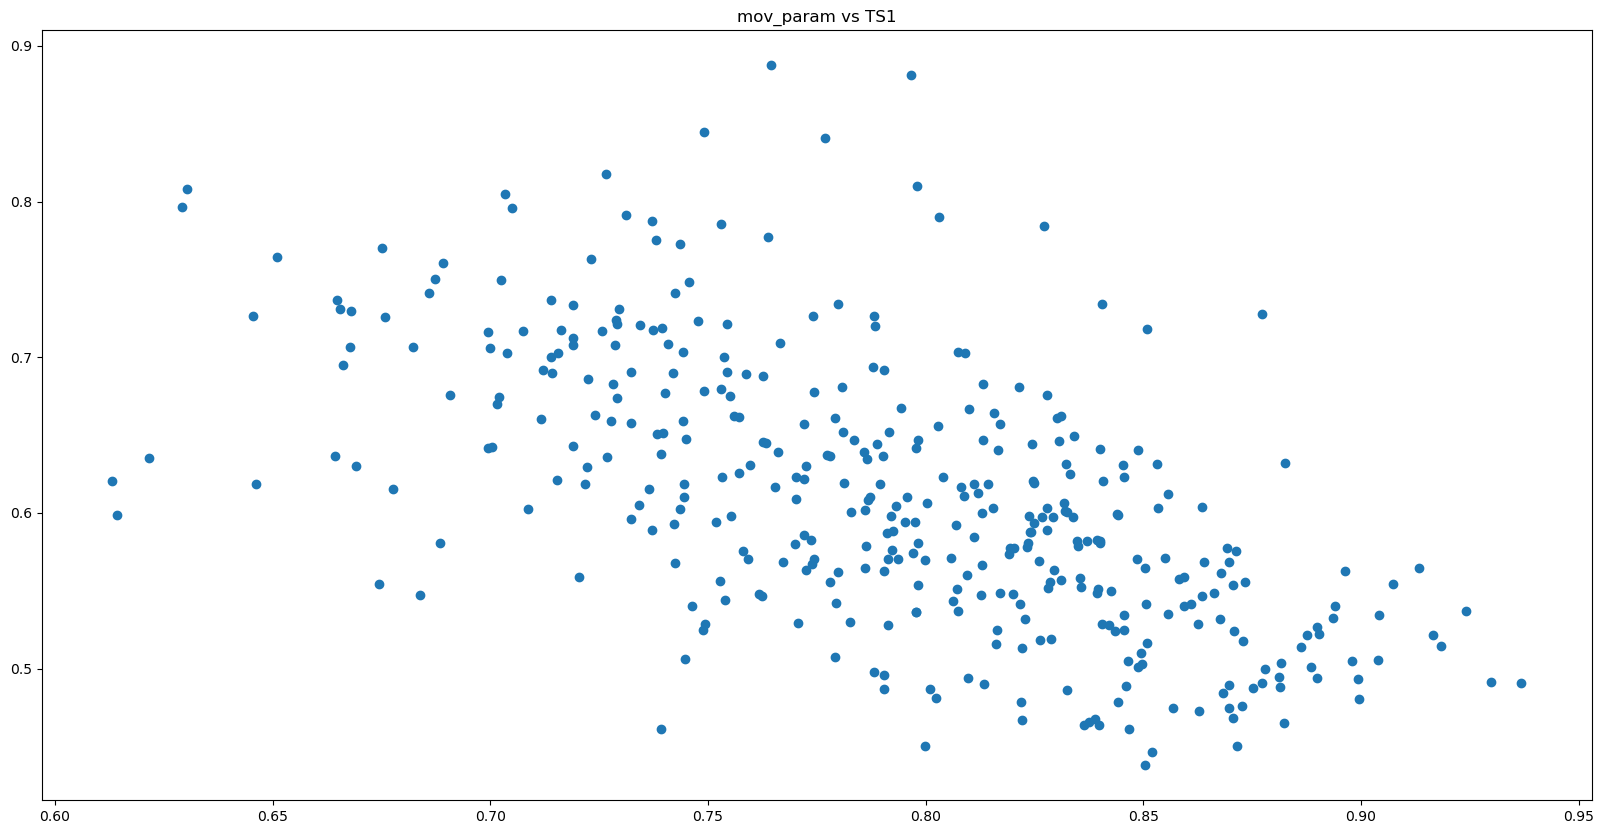

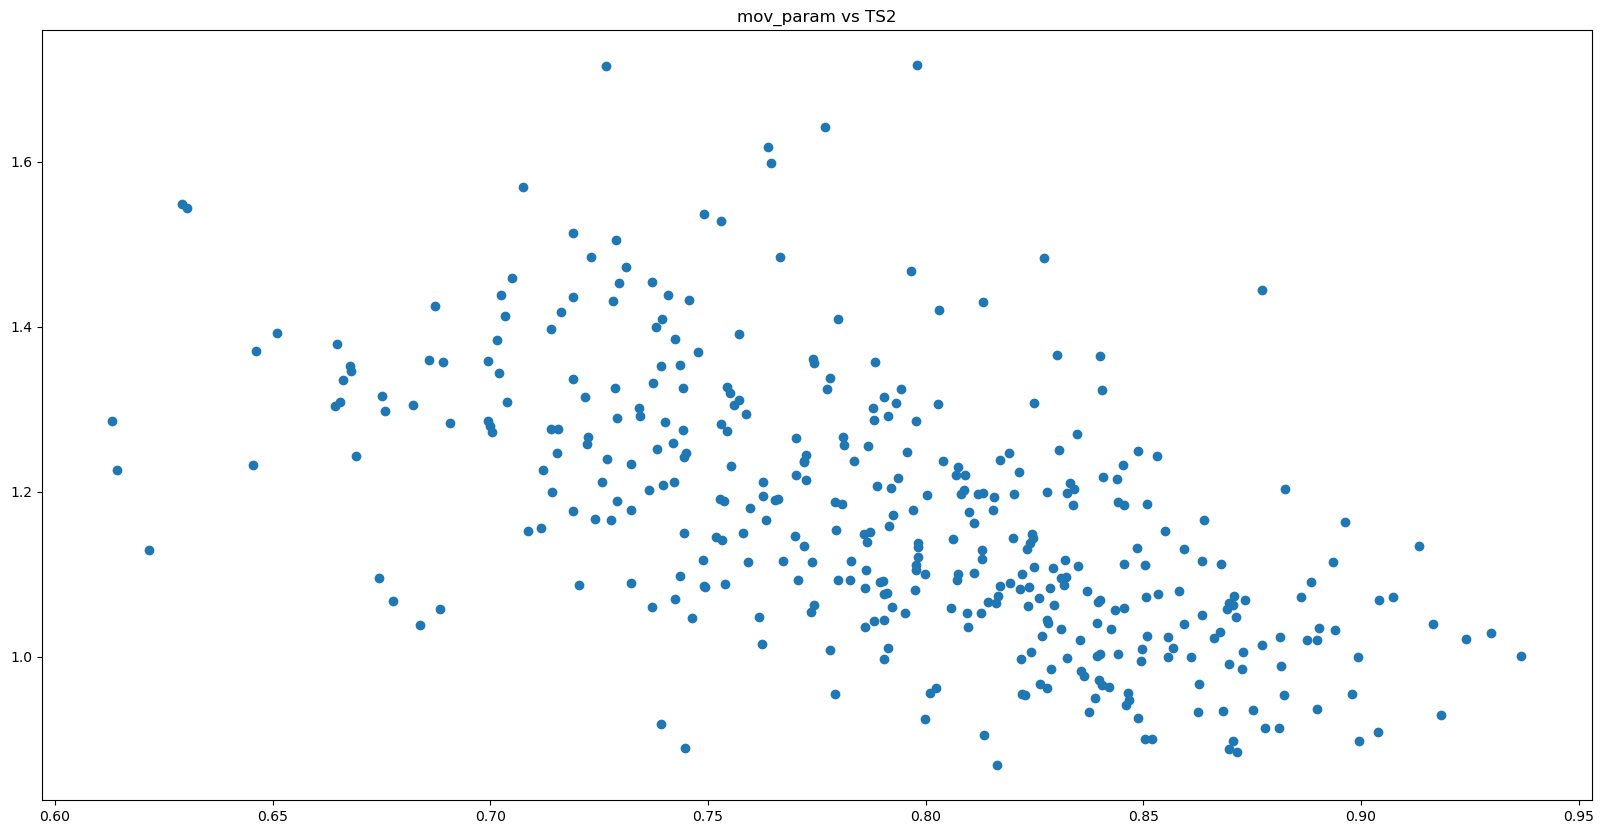

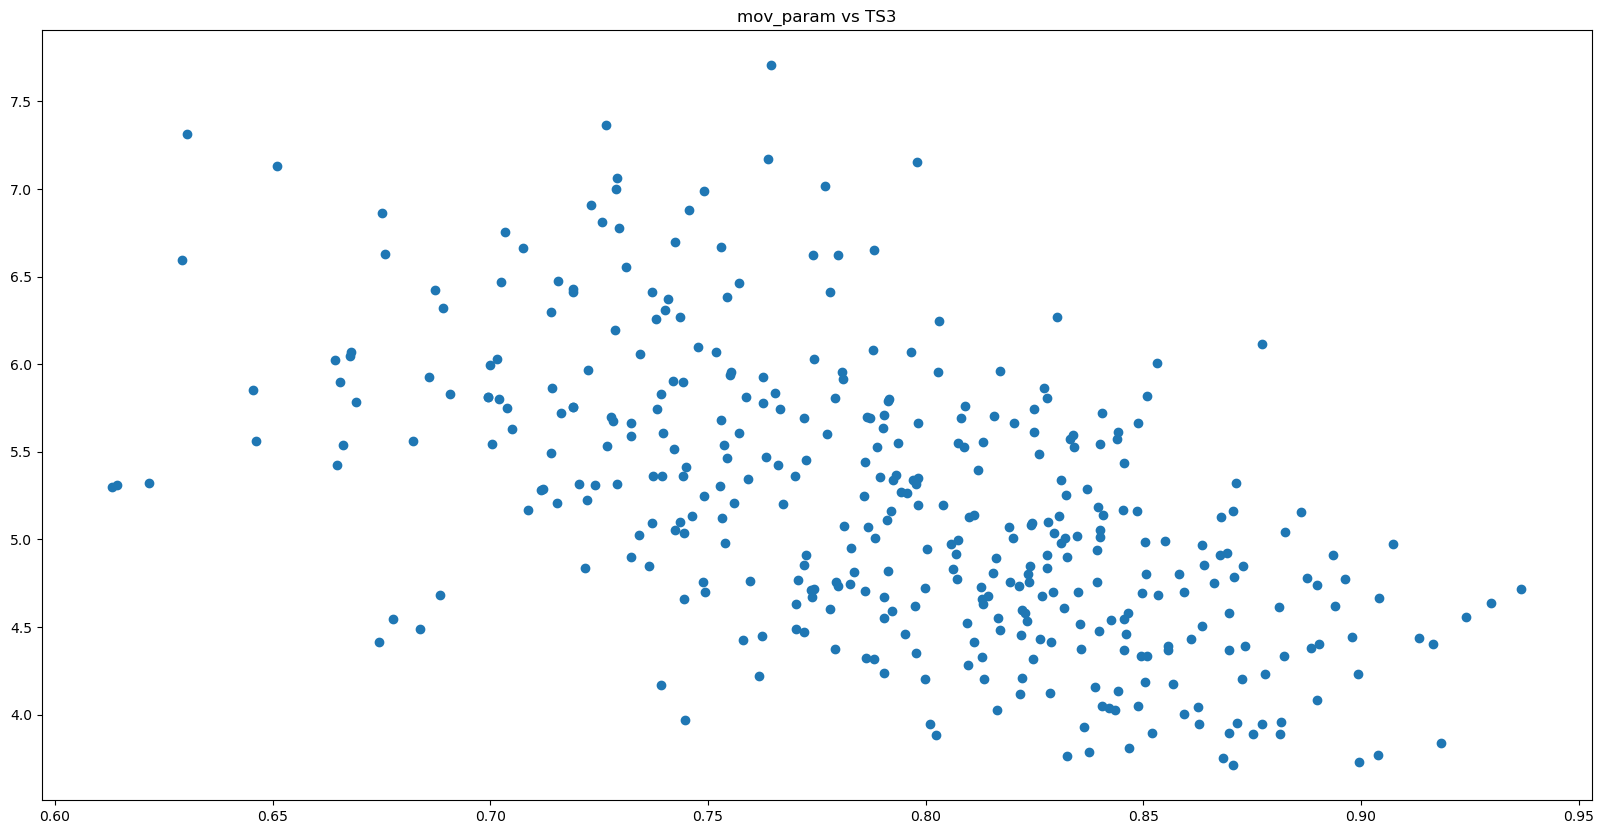

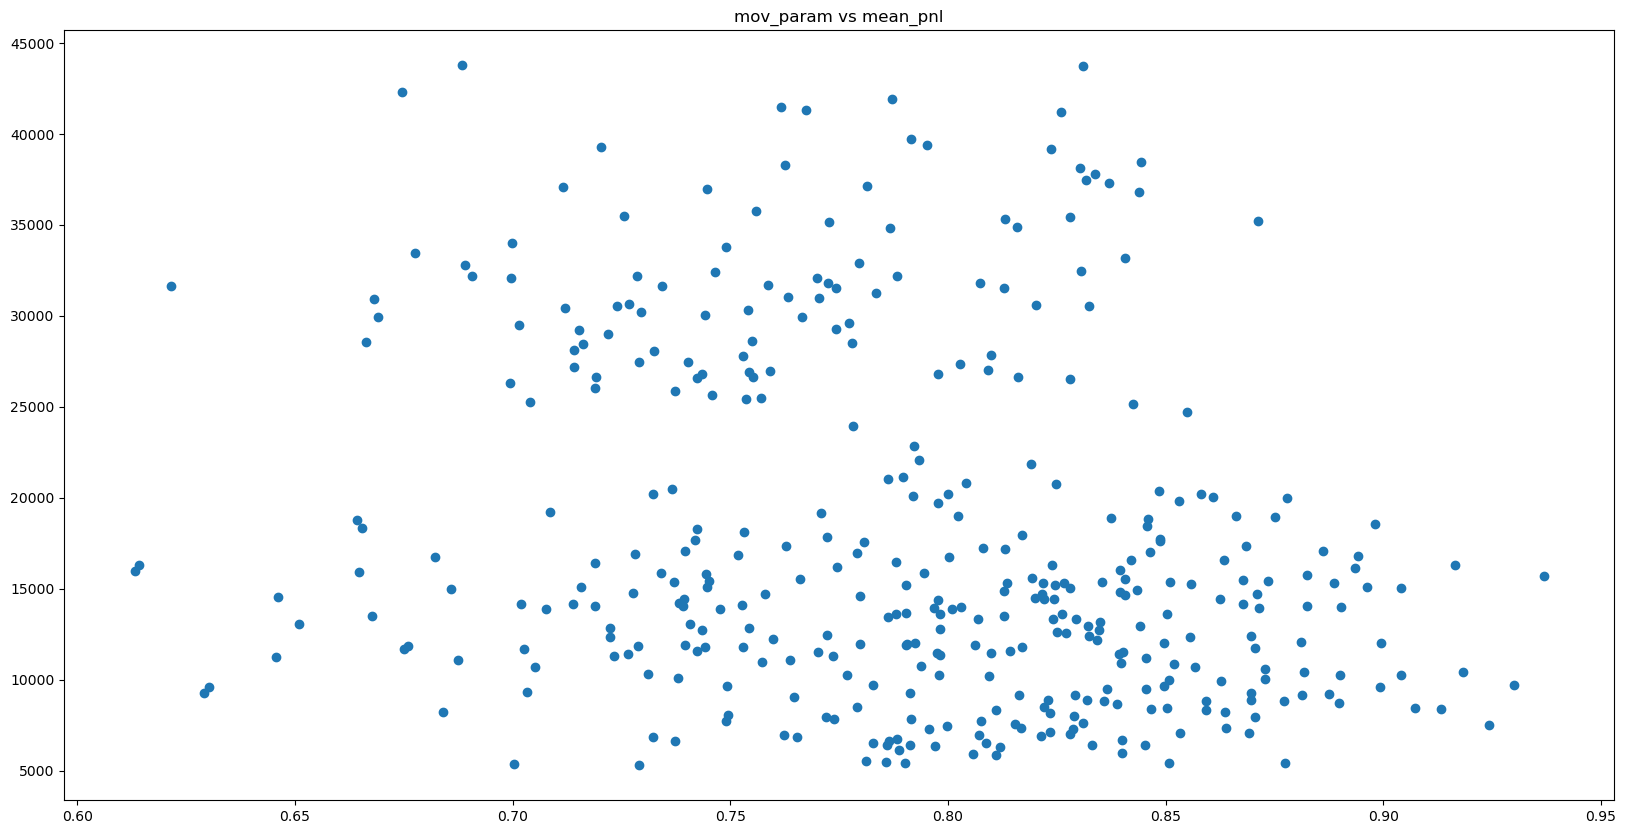

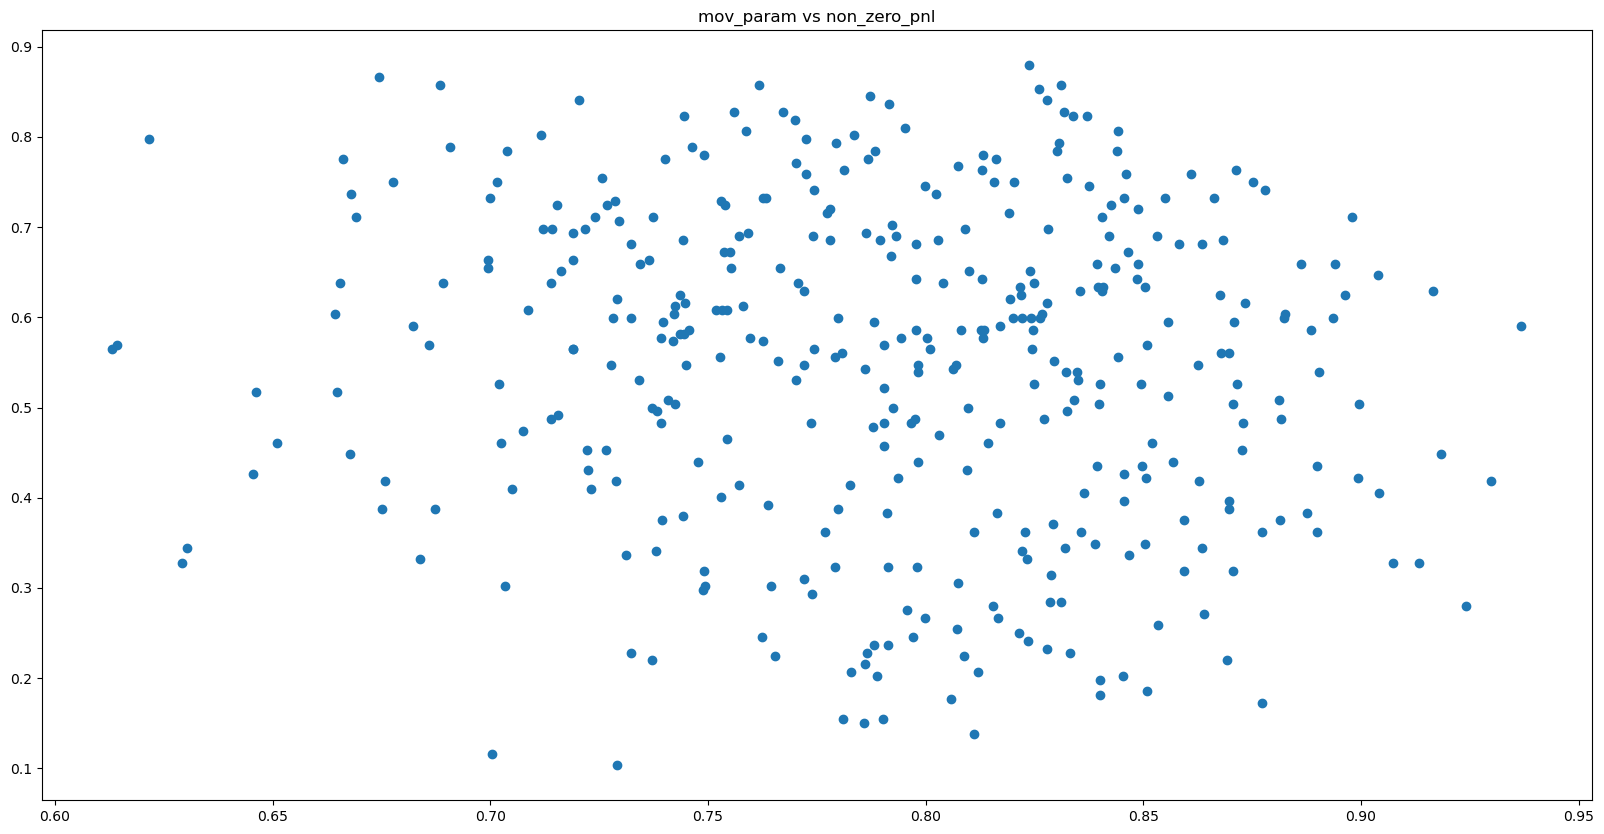

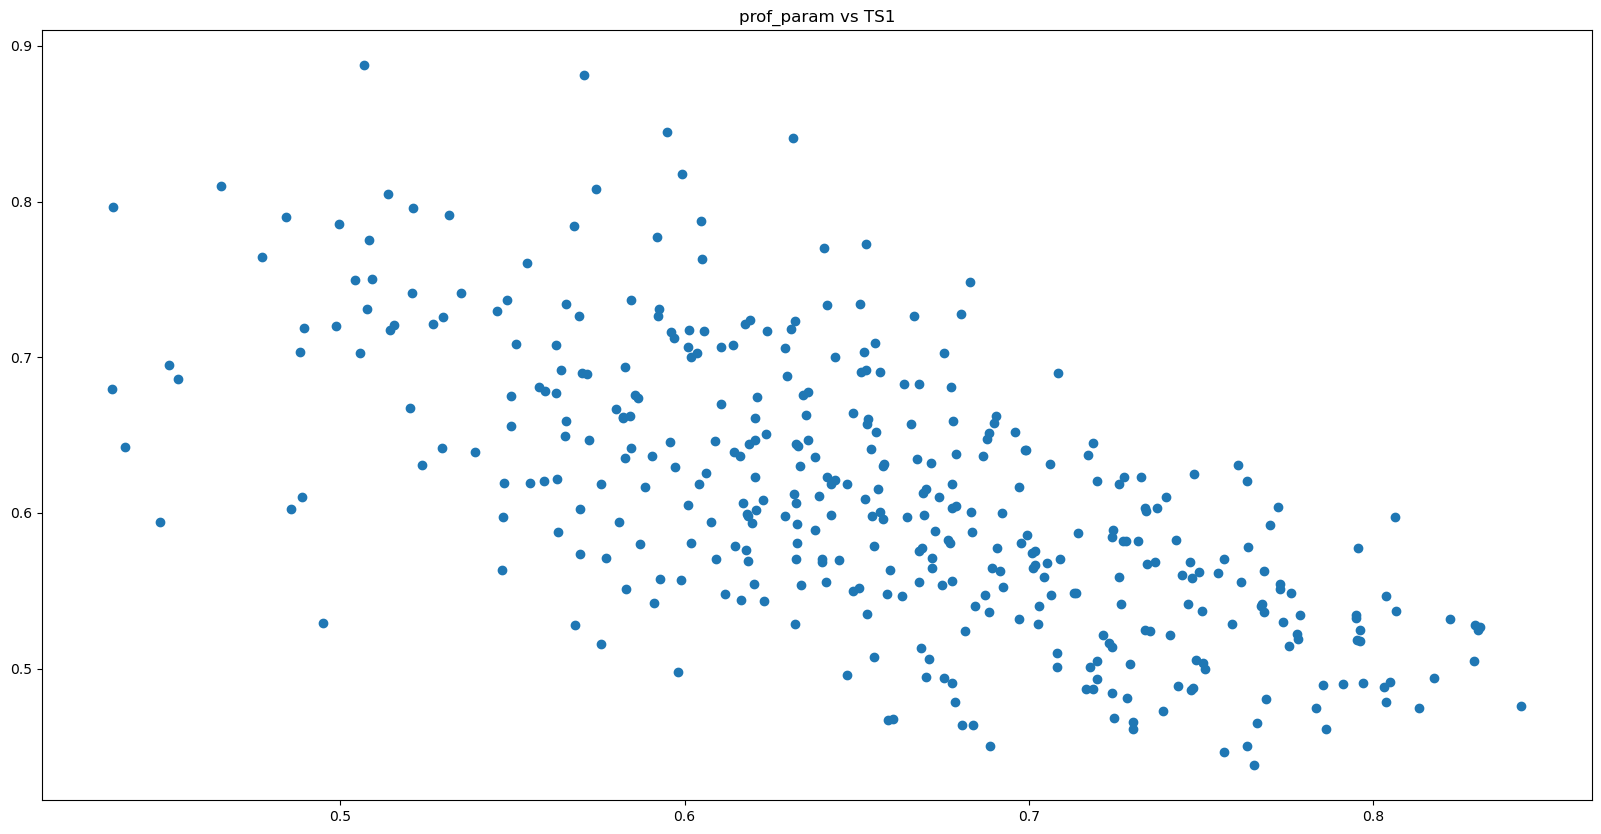

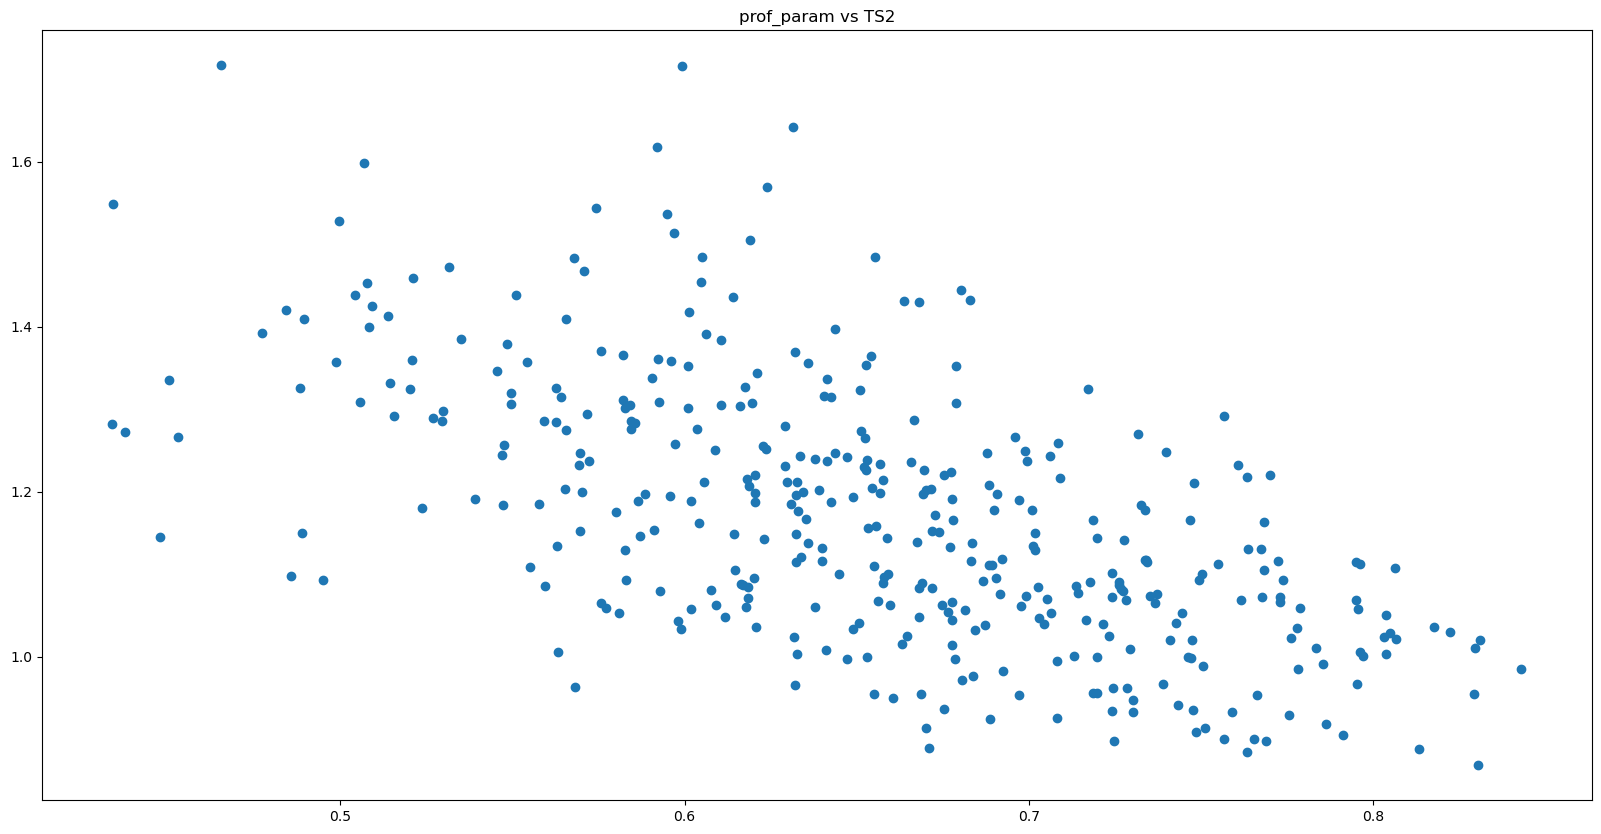

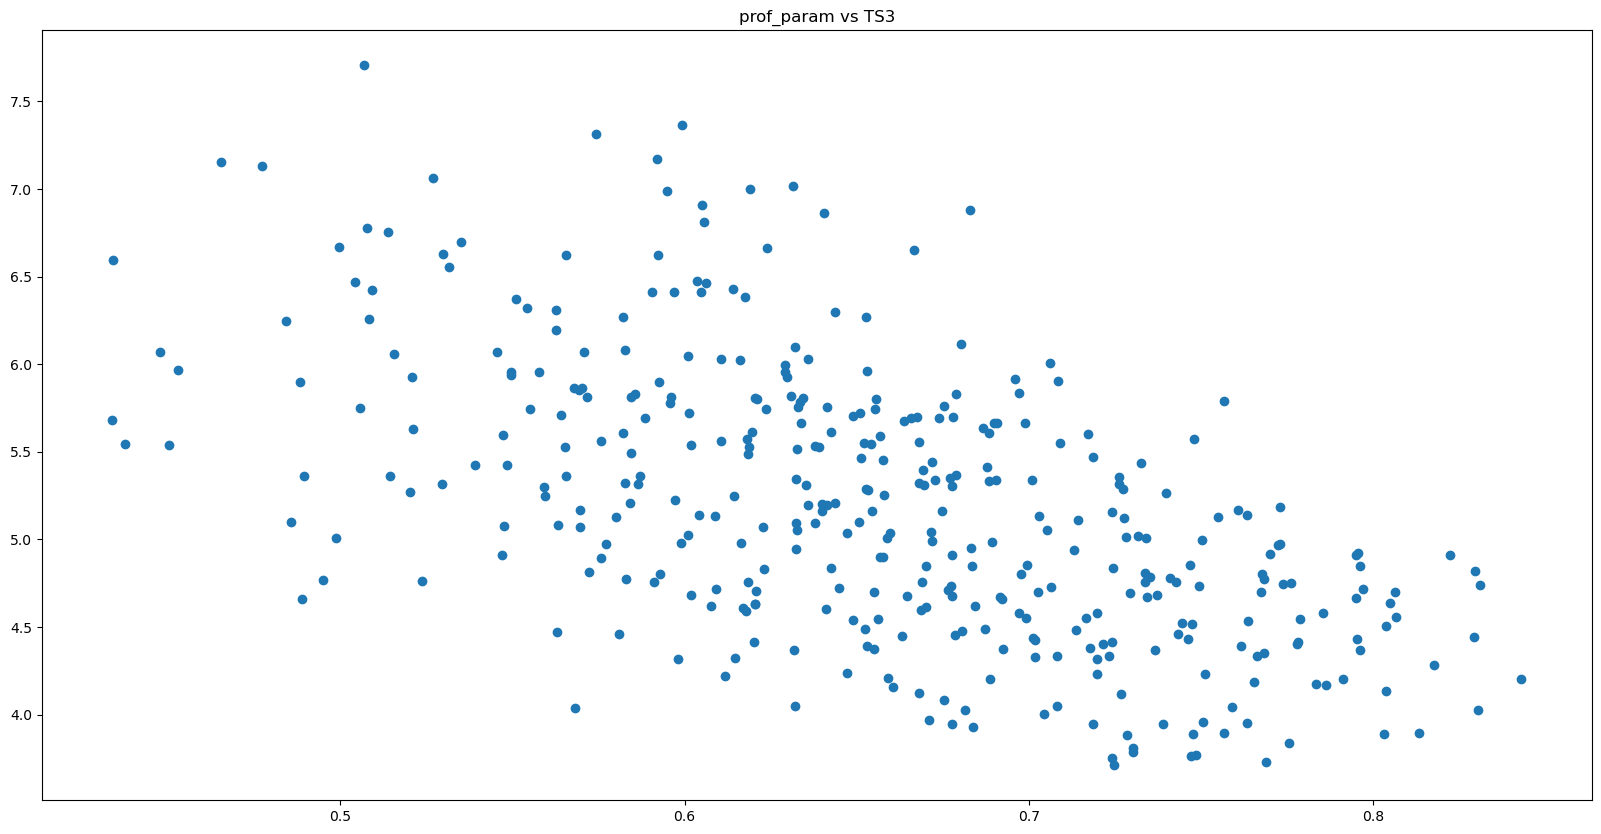

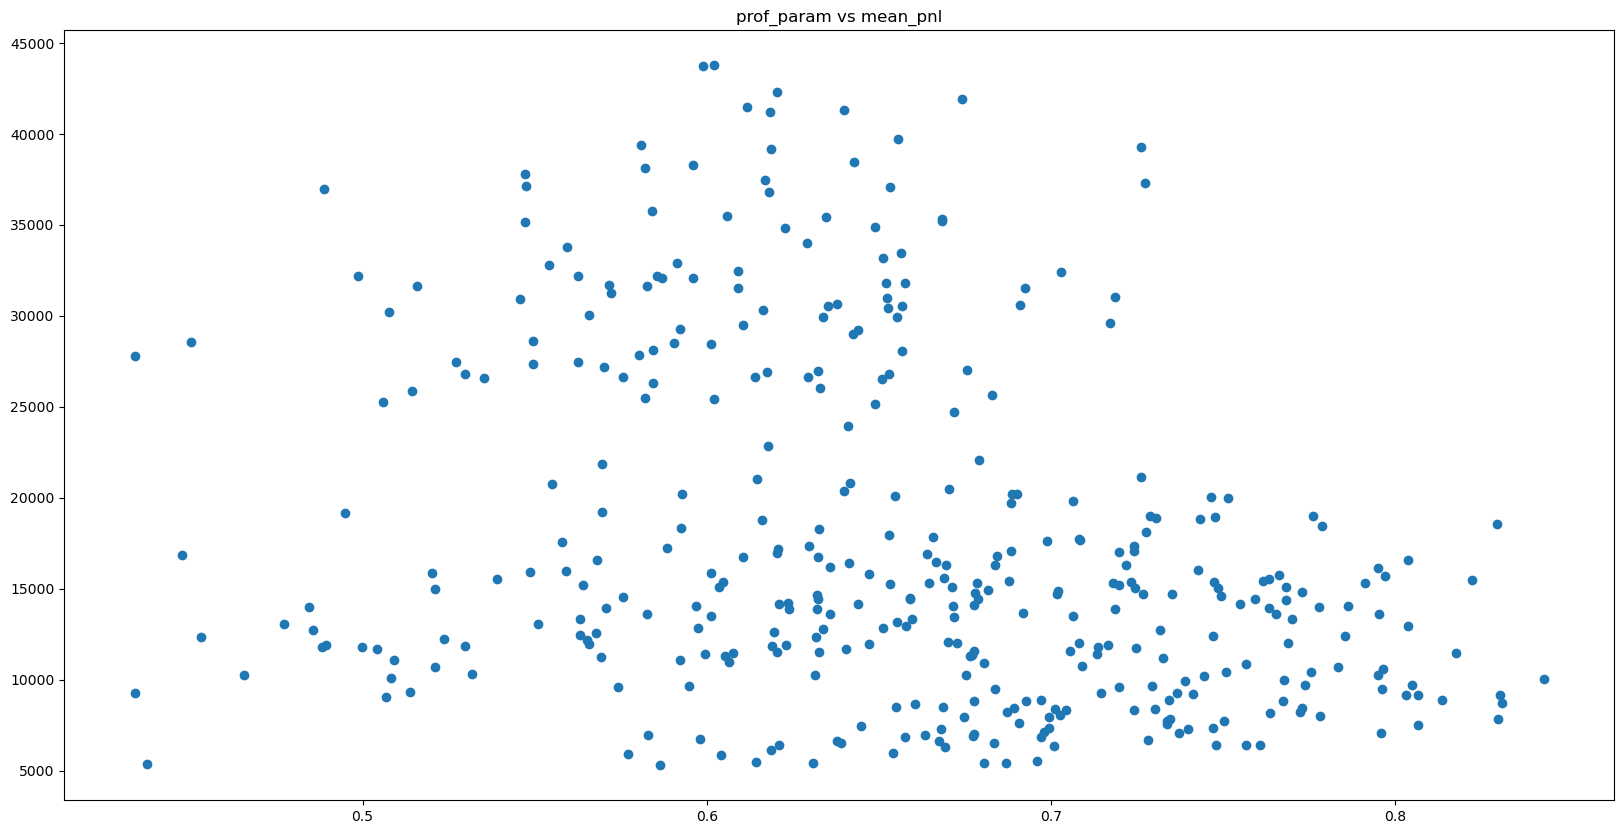

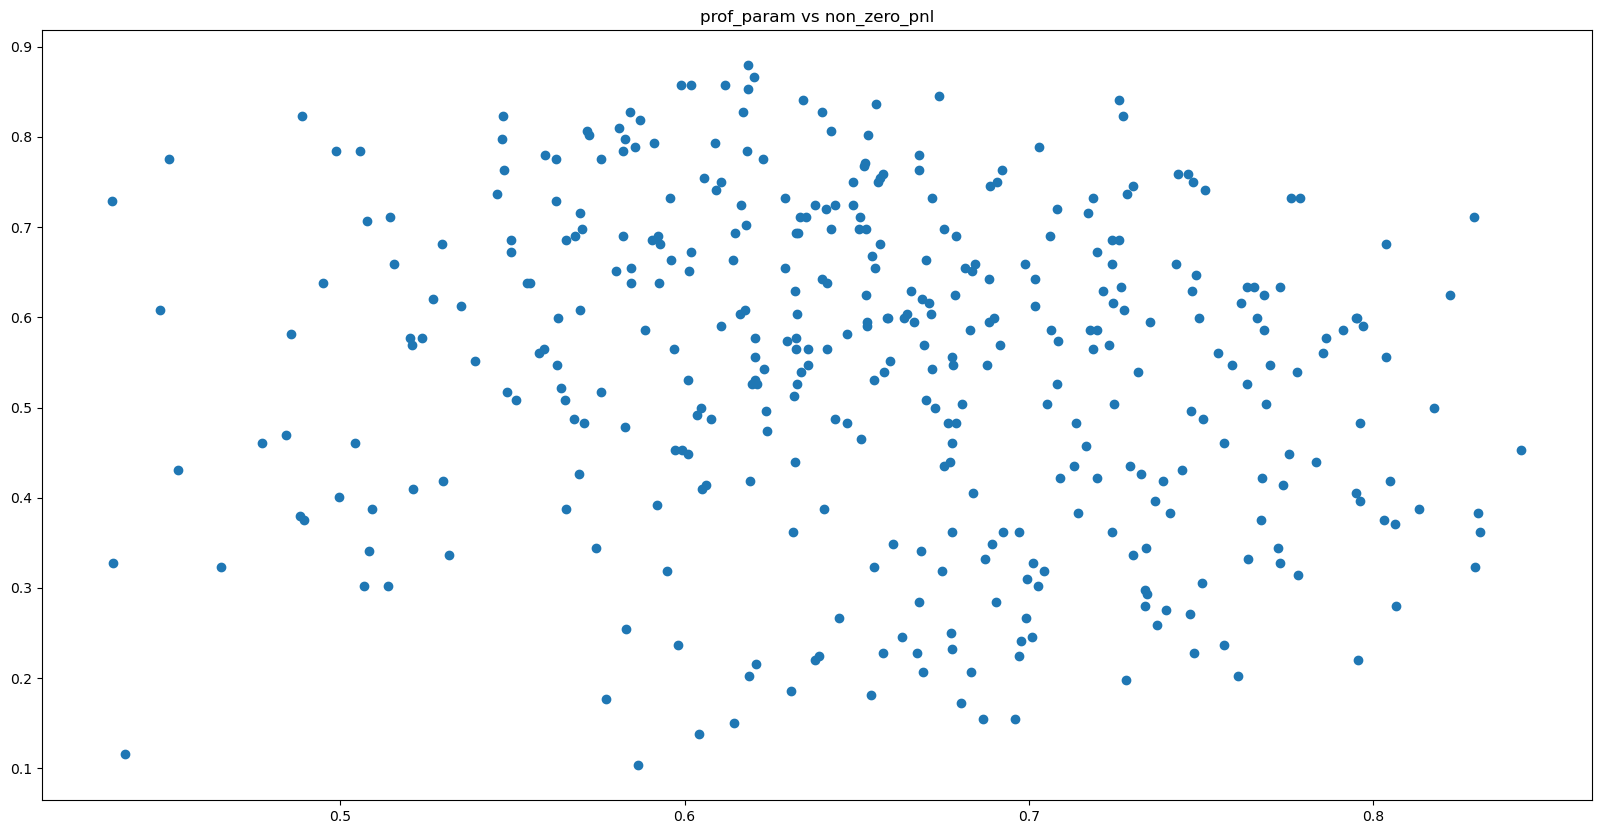

FileNotFoundError: [Errno 2] No such file or directory: 'pos_errors_NIFTY'

In [6]:
prof_corr=[]
pos_corr=[]
mov_corr=[]
mean_pnl=[]
non_zero_pnl=[]
ts1=[]
ts2=[]
ts3=[]
ts1_max=[]
ts2_max=[]
ts3_max=[]
ts1_min=[]
ts2_min=[]
ts3_min=[]

pos_df=pd.DataFrame(index=df.date.unique())
mov_df=pd.DataFrame(index=df.date.unique())
prof_df=pd.DataFrame(index=df.date.unique())
pos_errors=pd.DataFrame()
mov_errors=pd.DataFrame()
prof_errors=pd.DataFrame()

for i in range(1,385):

    sub_=df[df.strategy_variant==i][["date","pos_param","mov_param","prof_param","pnl","taylor_sensitivity_1","taylor_sensitivity_2","taylor_sensitivity_3"]]
    sub_.sort_values('date',inplace=True)
    sub=sub_[["date","pos_param","mov_param","prof_param"]]
    sub["lagged_pos_param"]=sub.pos_param.shift()
    sub["lagged_mov_param"]=sub.mov_param.shift()
    sub["lagged_prof_param"]=sub.prof_param.shift()
    mean_pnl.append(sub_.pnl.mean())
    non_zero_pnl.append(len(sub_[sub_.pnl>10000])/len(sub_))
    ts1.append(sub_.taylor_sensitivity_1.median())
    ts2.append(sub_.taylor_sensitivity_2.median())
    ts3.append(sub_.taylor_sensitivity_3.median())
    ts1_max.append(sub_.taylor_sensitivity_1.max())
    ts2_max.append(sub_.taylor_sensitivity_2.max())
    ts3_max.append(sub_.taylor_sensitivity_3.max())
    ts1_min.append(sub_.taylor_sensitivity_1.min())
    ts2_min.append(sub_.taylor_sensitivity_2.min())
    ts3_min.append(sub_.taylor_sensitivity_3.min())
    pos_df[i]=pos_df.index.map(sub.set_index('date').pos_param.to_dict())
    mov_df[i]=mov_df.index.map(sub.set_index('date').mov_param.to_dict())
    prof_df[i]=prof_df.index.map(sub.set_index('date').prof_param.to_dict())
    j=sub.corr()
    pos_corr.append(j.iloc[3,0])
    mov_corr.append(j.iloc[4,1])
    prof_corr.append(j.iloc[5,2])
    #pos_errors[i]=pred_errors(list(sub.pos_param))
    #mov_errors[i]=pred_errors(list(sub.mov_param))
    #prof_errors[i]=pred_errors(list(sub.prof_param))
    sub.dropna(inplace=True)

pos_df=pos_df.corr()
pos_df[pos_df==1]=0
mov_df=mov_df.corr()
mov_df[mov_df==1]=0
prof_df=prof_df.corr()
prof_df[prof_df==1]=0
p=len(pos_df)

plt.figure(figsize=(20,10))
plt.plot(pos_corr,label="pos_corr")
plt.title(f"pos_corr_self: Max={round(max(pos_corr),2)}, Mean= {round((sum(pos_corr)/len(pos_corr))*p/(p-1),2)}, Min={round(min(pos_corr),2)}")
plt.legend()
plt.show()
plt.figure(figsize=(20,10))
plt.plot(mov_corr,label="mov_corr")
plt.title(f"mov_corr_self: Max={round(max(mov_corr),2)}, Mean= {round((sum(mov_corr)/len(mov_corr))*p/(p-1),2)}, Min={round(min(mov_corr),2)}")
plt.legend()
plt.show()
plt.figure(figsize=(20,10))
plt.plot(prof_corr,label="prof_corr")
plt.title(f"prof_corr_self: Max={round(max(prof_corr),2)}, Mean= {round((sum(prof_corr)/len(prof_corr))*p/(p-1),2)}, Min={round(min(prof_corr),2)}")
plt.legend()
plt.show()
fig, ax1 = plt.subplots(figsize=(20,10))
ax1.plot(mean_pnl,label="mean_pnl")
ax1.set_ylabel('mean_pnl')
plt.legend()
ax2=ax1.twinx()
ax2.plot(non_zero_pnl,label="non_zero_pnl",color="g")
ax2.set_ylabel('non_zero_pnl')
plt.legend()
plt.show()
plt.figure(figsize=(20,10))
plt.plot(ts1,label="ts1_mean")
plt.plot(ts2,label="ts2_mean")
plt.legend()
plt.show()
plt.figure(figsize=(20,10))
plt.plot(ts3,label="ts3_mean")
plt.legend()
plt.show()
plt.figure(figsize=(20,10))
plt.plot(ts1_max,label="ts1_max")
plt.legend()
plt.show()
plt.figure(figsize=(20,10))
plt.plot(ts2_max,label="ts2_max")
plt.legend()
plt.show()
plt.figure(figsize=(20,10))
plt.plot(ts3_max,label="ts3_max")
plt.legend()
plt.show()
plt.figure(figsize=(20,10))
plt.plot(ts1_min,label="ts1_min")
plt.legend()
plt.show()
plt.figure(figsize=(20,10))
plt.plot(ts2_min,label="ts2_min")
plt.legend()
plt.show()
plt.figure(figsize=(20,10))
plt.plot(ts3_min,label="ts3_min")
plt.legend()
plt.show()

plt.figure(figsize=(20,10))
plt.plot(pos_df.min(),label="min_corr")
plt.plot(pos_df.mean(),label="mean_corr")
plt.plot(pos_df.max(),label="max_corr")
plt.title(f"pos_param: Max = {round(pos_df.to_numpy().max(),2)}, Mean = {round(pos_df.to_numpy().mean()*p/(p-1),2)}, Min = {round(pos_df.to_numpy().min(),2)}")
plt.legend()
plt.show()

plt.figure(figsize=(20,10))
plt.plot(mov_df.min(),label="min_corr")
plt.plot(mov_df.mean(),label="mean_corr")
plt.plot(mov_df.max(),label="max_corr")
plt.title(f"mov_param: Max={round(mov_df.to_numpy().max(),2)}, Mean= {round(mov_df.to_numpy().mean()*p/(p-1),2)}, Min={round(mov_df.to_numpy().min(),2)}")
plt.legend()
plt.show()

plt.figure(figsize=(20,10))
plt.plot(prof_df.min(),label="min_corr")
plt.plot(prof_df.mean(),label="mean_corr")
plt.plot(prof_df.max(),label="max_corr")
plt.title(f"prof_param: Max={round(prof_df.to_numpy().max(),2)}, Mean= {round(prof_df.to_numpy().mean()*p/(p-1),2)}, Min={round(prof_df.to_numpy().min(),2)}")
plt.legend()
plt.show()

plt.figure(figsize=(20,10))
plt.scatter(mean_pnl,non_zero_pnl)
plt.title("Mean PnL vs Non-Zero PnL percentage")
plt.show()
plt.figure(figsize=(20,10))
plt.scatter(mean_pnl,ts1)
plt.title("Mean PnL vs TS1")
plt.show()
plt.figure(figsize=(20,10))
plt.scatter(non_zero_pnl,ts1)
plt.title("Non-Zero PnL percentage vs TS1")
plt.show()
plt.figure(figsize=(20,10))
plt.scatter(mean_pnl,ts2)
plt.title("Mean PnL vs TS2")
plt.show()
plt.figure(figsize=(20,10))
plt.scatter(non_zero_pnl,ts2)
plt.title("Non-Zero PnL percentage vs TS2")
plt.show()
plt.figure(figsize=(20,10))
plt.scatter(mean_pnl,ts3)
plt.title("Mean PnL vs TS3")
plt.show()
plt.figure(figsize=(20,10))
plt.scatter(non_zero_pnl,ts3)
plt.title("Non-Zero PnL percentage vs TS3")
plt.show()
plt.figure(figsize=(20,10))
plt.scatter(pos_corr,ts1)
plt.title("pos_param vs TS1")
plt.show()
plt.figure(figsize=(20,10))
plt.scatter(pos_corr,ts2)
plt.title("pos_param vs TS2")
plt.show()
plt.figure(figsize=(20,10))
plt.scatter(pos_corr,ts3)
plt.title("pos_param vs TS3")
plt.show()
plt.figure(figsize=(20,10))
plt.scatter(pos_corr,mean_pnl)
plt.title("pos_param vs mean_pnl")
plt.show()
plt.figure(figsize=(20,10))
plt.scatter(pos_corr,non_zero_pnl)
plt.title("pos_param vs non_zero_pnl")
plt.show()
plt.figure(figsize=(20,10))
plt.scatter(mov_corr,ts1)
plt.title("mov_param vs TS1")
plt.show()
plt.figure(figsize=(20,10))
plt.scatter(mov_corr,ts2)
plt.title("mov_param vs TS2")
plt.show()
plt.figure(figsize=(20,10))
plt.scatter(mov_corr,ts3)
plt.title("mov_param vs TS3")
plt.show()
plt.figure(figsize=(20,10))
plt.scatter(mov_corr,mean_pnl)
plt.title("mov_param vs mean_pnl")
plt.show()
plt.figure(figsize=(20,10))
plt.scatter(mov_corr,non_zero_pnl)
plt.title("mov_param vs non_zero_pnl")
plt.show()
plt.figure(figsize=(20,10))
plt.scatter(prof_corr,ts1)
plt.title("prof_param vs TS1")
plt.show()
plt.figure(figsize=(20,10))
plt.scatter(prof_corr,ts2)
plt.title("prof_param vs TS2")
plt.show()
plt.figure(figsize=(20,10))
plt.scatter(prof_corr,ts3)
plt.title("prof_param vs TS3")
plt.show()
plt.figure(figsize=(20,10))
plt.scatter(prof_corr,mean_pnl)
plt.title("prof_param vs mean_pnl")
plt.show()
plt.figure(figsize=(20,10))
plt.scatter(prof_corr,non_zero_pnl)
plt.title("prof_param vs non_zero_pnl")
plt.show()

#pos_errors["date"]=sorted(df.date.unique())[100:]
#mov_errors["date"]=pos_errors["date"]
#prof_errors["date"]=pos_errors["date"]
pos_errors=pd.read_csv("pos_errors_NIFTY")
mov_errors=pd.read_csv("mov_errors_NIFTY")
prof_errors=pd.read_csv("prof_errors_NIFTY")

pos_errors.set_index('date',inplace=True)
mov_errors.set_index('date',inplace=True)
prof_errors.set_index('date',inplace=True)
pos_errors_=pos_errors.corr()
mov_errors_=mov_errors.corr()
prof_errors_=prof_errors.corr()
pos_errors_[pos_errors_==1]=0
mov_errors_[mov_errors_==1]=0
prof_errors_[prof_errors_==1]=0

plt.figure(figsize=(20,10))
plt.plot(pos_errors_.min(),label="min_corr")
plt.plot(pos_errors_.mean(),label="mean_corr")
plt.plot(pos_errors_.max(),label="max_corr")
plt.title(f"pos_errors_self: Max={round(pos_errors_.to_numpy().max(),2)}, Mean= {round(pos_errors_.to_numpy().mean()*p/(p-1),2)}, Min={round(pos_errors_.to_numpy().min(),2)}")
plt.legend()
plt.show()

plt.figure(figsize=(20,10))
plt.plot(mov_errors_.min(),label="min_corr")
plt.plot(mov_errors_.mean(),label="mean_corr")
plt.plot(mov_errors_.max(),label="max_corr")
plt.title(f"mov_errors_self: Max={round(mov_errors_.to_numpy().max(),2)}, Mean= {round(mov_errors_.to_numpy().mean()*p/(p-1),2)}, Min={round(mov_errors_.to_numpy().min(),2)}")
plt.legend()
plt.show()

plt.figure(figsize=(20,10))
plt.plot(prof_errors_.min(),label="min_corr")
plt.plot(prof_errors_.mean(),label="mean_corr")
plt.plot(prof_errors_.max(),label="max_corr")
plt.title(f"prof_errors_self: Max={round(prof_errors_.to_numpy().max(),2)}, Mean= {round(prof_errors_.to_numpy().mean()*p/(p-1),2)}, Min={round(prof_errors_.to_numpy().min(),2)}")
plt.legend()
plt.show()
"""
df_=df[df.date.isin(prof_errors.index)][["date","strategy_variant","pos_param","mov_param","prof_param","sim_vol"]].sort_values(['date','strategy_variant']).set_index('date')
pivot_pos=pd.pivot_table(df_[["strategy_variant","pos_param"]],index=['date'],columns=['strategy_variant'],values=['pos_param'])
pivot_pos.columns=[n for p,n in pivot_pos.columns]
pivot_mov=pd.pivot_table(df_[["strategy_variant","mov_param"]],index=['date'],columns=['strategy_variant'],values=['mov_param'])
pivot_mov.columns=[n for p,n in pivot_mov.columns]
pivot_prof=pd.pivot_table(df_[["strategy_variant","prof_param"]],index=['date'],columns=['strategy_variant'],values=['prof_param'])
pivot_prof.columns=[n for p,n in pivot_prof.columns]
pivot_sim_vol=pd.pivot_table(df_[["strategy_variant","sim_vol"]],index=['date'],columns=['strategy_variant'],values=['sim_vol'])
pivot_sim_vol.columns=[n for p,n in pivot_sim_vol.columns]

pivot=pivot_pos
pos_errors_corr_pos_params_lagged=pd.DataFrame(index=pivot.columns,columns=pivot.columns)
mov_errors_corr_pos_params_lagged=pd.DataFrame(index=pivot.columns,columns=pivot.columns)
prof_errors_corr_pos_params_lagged=pd.DataFrame(index=pivot.columns,columns=pivot.columns)
pos_errors_corr_pos_params_lagged_diff=pd.DataFrame(index=pivot.columns,columns=pivot.columns)
mov_errors_corr_pos_params_lagged_diff=pd.DataFrame(index=pivot.columns,columns=pivot.columns)
prof_errors_corr_pos_params_lagged_diff=pd.DataFrame(index=pivot.columns,columns=pivot.columns)
pos_errors_corr_mov_params_lagged=pd.DataFrame(index=pivot.columns,columns=pivot.columns)
mov_errors_corr_mov_params_lagged=pd.DataFrame(index=pivot.columns,columns=pivot.columns)
prof_errors_corr_mov_params_lagged=pd.DataFrame(index=pivot.columns,columns=pivot.columns)
pos_errors_corr_mov_params_lagged_diff=pd.DataFrame(index=pivot.columns,columns=pivot.columns)
mov_errors_corr_mov_params_lagged_diff=pd.DataFrame(index=pivot.columns,columns=pivot.columns)
prof_errors_corr_mov_params_lagged_diff=pd.DataFrame(index=pivot.columns,columns=pivot.columns)
pos_errors_corr_prof_params_lagged=pd.DataFrame(index=pivot.columns,columns=pivot.columns)
mov_errors_corr_prof_params_lagged=pd.DataFrame(index=pivot.columns,columns=pivot.columns)
prof_errors_corr_prof_params_lagged=pd.DataFrame(index=pivot.columns,columns=pivot.columns)
pos_errors_corr_prof_params_lagged_diff=pd.DataFrame(index=pivot.columns,columns=pivot.columns)
mov_errors_corr_prof_params_lagged_diff=pd.DataFrame(index=pivot.columns,columns=pivot.columns)
prof_errors_corr_prof_params_lagged_diff=pd.DataFrame(index=pivot.columns,columns=pivot.columns)
pos_errors_corr_sim_vol_lagged=pd.DataFrame(index=pivot.columns,columns=pivot.columns)
mov_errors_corr_sim_vol_lagged=pd.DataFrame(index=pivot.columns,columns=pivot.columns)
prof_errors_corr_sim_vol_lagged=pd.DataFrame(index=pivot.columns,columns=pivot.columns)
pos_errors_corr_sim_vol_lagged_diff=pd.DataFrame(index=pivot.columns,columns=pivot.columns)
mov_errors_corr_sim_vol_lagged_diff=pd.DataFrame(index=pivot.columns,columns=pivot.columns)
prof_errors_corr_sim_vol_lagged_diff=pd.DataFrame(index=pivot.columns,columns=pivot.columns)

for col in pos_errors.columns:
    print(col)
    pivot_pos_=pivot_pos.copy()
    pivot_pos_[int(col)]=pos_errors[col]
    pivot_pos_[int(col)]=pivot_pos_[int(col)].shift(-1)
    pivot_pos_.dropna(inplace=True)
    pos_errors_corr_pos_params_lagged[int(col)]=pivot_pos_.corr()[int(col)]
    pivot_pos_[int(col)]=mov_errors[col].shift(-1).dropna()
    mov_errors_corr_pos_params_lagged[int(col)]=pivot_pos_.corr()[int(col)]
    pivot_pos_[int(col)]=prof_errors[col].shift(-1).dropna()
    prof_errors_corr_pos_params_lagged[int(col)]=pivot_pos_.corr()[int(col)]

    
    pivot_pos_=pivot_pos.copy()
    pivot_pos_=pivot_pos_.diff()
    pivot_pos_[int(col)]=pos_errors[col]
    pivot_pos_[int(col)]=pivot_pos_[int(col)].shift(-1)
    pivot_pos_.dropna(inplace=True)
    pos_errors_corr_pos_params_lagged_diff[int(col)]=pivot_pos_.corr()[int(col)]
    pivot_pos_[int(col)]=mov_errors[col].shift(-1)[1:].dropna()
    mov_errors_corr_pos_params_lagged_diff[int(col)]=pivot_pos_.corr()[int(col)]
    pivot_pos_[int(col)]=prof_errors[col].shift(-1)[1:].dropna()
    prof_errors_corr_pos_params_lagged_diff[int(col)]=pivot_pos_.corr()[int(col)]

    
    pivot_mov_=pivot_mov.copy()
    pivot_mov_[int(col)]=pos_errors[col]
    pivot_mov_[int(col)]=pivot_mov_[int(col)].shift(-1)
    pivot_mov_.dropna(inplace=True)
    pos_errors_corr_mov_params_lagged[int(col)]=pivot_mov_.corr()[int(col)]
    pivot_mov_[int(col)]=mov_errors[col].shift(-1).dropna()
    mov_errors_corr_mov_params_lagged[int(col)]=pivot_mov_.corr()[int(col)]
    pivot_mov_[int(col)]=prof_errors[col].shift(-1).dropna()
    prof_errors_corr_mov_params_lagged[int(col)]=pivot_mov_.corr()[int(col)]

    pivot_mov_=pivot_mov.copy()
    pivot_mov_=pivot_mov_.diff()
    pivot_mov_[int(col)]=pos_errors[col]
    pivot_mov_[int(col)]=pivot_mov_[int(col)].shift(-1)
    pivot_mov_.dropna(inplace=True)
    pos_errors_corr_mov_params_lagged_diff[int(col)]=pivot_mov_.corr()[int(col)]
    pivot_mov_[int(col)]=mov_errors[col].shift(-1)[1:].dropna()
    mov_errors_corr_mov_params_lagged_diff[int(col)]=pivot_mov_.corr()[int(col)]
    pivot_mov_[int(col)]=prof_errors[col].shift(-1)[1:].dropna()
    prof_errors_corr_mov_params_lagged_diff[int(col)]=pivot_mov_.corr()[int(col)]

    
    
    pivot_prof_=pivot_prof.copy()
    pivot_prof_[int(col)]=pos_errors[col]
    pivot_prof_[int(col)]=pivot_prof_[int(col)].shift(-1)
    pivot_prof_.dropna(inplace=True)
    pos_errors_corr_prof_params_lagged[int(col)]=pivot_prof_.corr()[int(col)]
    pivot_prof_[int(col)]=mov_errors[col].shift(-1).dropna()
    mov_errors_corr_prof_params_lagged[int(col)]=pivot_prof_.corr()[int(col)]
    pivot_prof_[int(col)]=prof_errors[col].shift(-1).dropna()
    prof_errors_corr_prof_params_lagged[int(col)]=pivot_prof_.corr()[int(col)]


    pivot_prof_=pivot_prof.copy()
    pivot_prof_=pivot_prof_.diff()
    pivot_prof_[int(col)]=pos_errors[col]
    pivot_prof_[int(col)]=pivot_prof_[int(col)].shift(-1)
    pivot_prof_.dropna(inplace=True)
    pos_errors_corr_prof_params_lagged_diff[int(col)]=pivot_prof_.corr()[int(col)]
    pivot_prof_[int(col)]=mov_errors[col].shift(-1)[1:].dropna()
    mov_errors_corr_prof_params_lagged_diff[int(col)]=pivot_prof_.corr()[int(col)]
    pivot_prof_[int(col)]=prof_errors[col].shift(-1)[1:].dropna()
    prof_errors_corr_prof_params_lagged_diff[int(col)]=pivot_prof_.corr()[int(col)]

    
    
    pivot_sim_vol_=pivot_sim_vol.copy()
    pivot_sim_vol_[int(col)]=pos_errors[col]
    pivot_sim_vol_[int(col)]=pivot_sim_vol_[int(col)].shift(-1)
    pivot_sim_vol_.dropna(inplace=True)
    pos_errors_corr_sim_vol_lagged[int(col)]=pivot_sim_vol_.corr()[int(col)]
    pivot_sim_vol_[int(col)]=mov_errors[col].shift(-1).dropna()
    mov_errors_corr_sim_vol_lagged[int(col)]=pivot_sim_vol_.corr()[int(col)]
    pivot_sim_vol_[int(col)]=prof_errors[col].shift(-1).dropna()
    prof_errors_corr_sim_vol_lagged[int(col)]=pivot_sim_vol_.corr()[int(col)]


    pivot_sim_vol_=pivot_sim_vol.copy()
    pivot_sim_vol_=pivot_sim_vol_.diff()
    pivot_sim_vol_[int(col)]=pos_errors[col]
    pivot_sim_vol_[int(col)]=pivot_sim_vol_[int(col)].shift(-1)
    pivot_sim_vol_.dropna(inplace=True)
    pos_errors_corr_sim_vol_lagged_diff[int(col)]=pivot_sim_vol_.corr()[int(col)]
    pivot_sim_vol_[int(col)]=mov_errors[col].shift(-1)[1:].dropna()
    mov_errors_corr_sim_vol_lagged_diff[int(col)]=pivot_sim_vol_.corr()[int(col)]
    pivot_sim_vol_[int(col)]=prof_errors[col].shift(-1)[1:].dropna()
    prof_errors_corr_sim_vol_lagged_diff[int(col)]=pivot_sim_vol_.corr()[int(col)]



corr=[pos_errors_corr_pos_params_lagged,mov_errors_corr_pos_params_lagged,prof_errors_corr_pos_params_lagged,
pos_errors_corr_pos_params_lagged_diff,mov_errors_corr_pos_params_lagged_diff,prof_errors_corr_pos_params_lagged_diff,
pos_errors_corr_mov_params_lagged,mov_errors_corr_mov_params_lagged,prof_errors_corr_mov_params_lagged,
pos_errors_corr_mov_params_lagged_diff,mov_errors_corr_mov_params_lagged_diff,prof_errors_corr_mov_params_lagged_diff,
pos_errors_corr_prof_params_lagged,mov_errors_corr_prof_params_lagged,prof_errors_corr_prof_params_lagged,
pos_errors_corr_prof_params_lagged_diff,mov_errors_corr_prof_params_lagged_diff,prof_errors_corr_prof_params_lagged_diff,
pos_errors_corr_sim_vol_lagged,mov_errors_corr_sim_vol_lagged,prof_errors_corr_sim_vol_lagged,
pos_errors_corr_sim_vol_lagged_diff,mov_errors_corr_sim_vol_lagged_diff,prof_errors_corr_sim_vol_lagged_diff]

corr_str=["pos_errors_corr_pos_params_lagged","mov_errors_corr_pos_params_lagged","prof_errors_corr_pos_params_lagged",
"pos_errors_corr_pos_params_lagged_diff","mov_errors_corr_pos_params_lagged_diff","prof_errors_corr_pos_params_lagged_diff",
"pos_errors_corr_mov_params_lagged","mov_errors_corr_mov_params_lagged","prof_errors_corr_mov_params_lagged",
"pos_errors_corr_mov_params_lagged_diff","mov_errors_corr_mov_params_lagged_diff","prof_errors_corr_mov_params_lagged_diff",
"pos_errors_corr_prof_params_lagged","mov_errors_corr_prof_params_lagged","prof_errors_corr_prof_params_lagged",
"pos_errors_corr_prof_params_lagged_diff","mov_errors_corr_prof_params_lagged_diff","prof_errors_corr_prof_params_lagged_diff",
"pos_errors_corr_sim_vol_lagged","mov_errors_corr_sim_vol_lagged","prof_errors_corr_sim_vol_lagged",
"pos_errors_corr_sim_vol_lagged_diff","mov_errors_corr_sim_vol_lagged_diff","prof_errors_corr_sim_vol_lagged_diff"]

for i, n in enumerate(corr):
    n[n==1]=0
    plt.figure(figsize=(20,10))
    plt.plot(n.min(),label="min_corr")
    plt.plot(n.mean(),label="mean_corr")
    plt.plot(n.max(),label="max_corr")
    plt.title(f"{corr_str[i]}: Max={round(n.to_numpy().max(),2)}, Mean= {round(n.to_numpy().mean()*p/(p-1),2)}, Min={round(n.to_numpy().min(),2)}")
    plt.show()
"""


In [ ]:
df=pd.read_csv('/Users/praneetshaw/Desktop/Strategy/Strategy_FIles/param.csv')
df.drop(columns=['_id', 'Unnamed: 0'], inplace = True)
df=df.head(675*384)
prof_corr=[]
pos_corr=[]
mov_corr=[]
mean_pnl=[]
non_zero_pnl=[]
ts1=[]
ts2=[]
ts3=[]
ts1_max=[]
ts2_max=[]
ts3_max=[]
ts1_min=[]
ts2_min=[]
ts3_min=[]

pos_df=pd.DataFrame(index=df.date.unique())
mov_df=pd.DataFrame(index=df.date.unique())
prof_df=pd.DataFrame(index=df.date.unique())
pos_errors=pd.DataFrame()
mov_errors=pd.DataFrame()
prof_errors=pd.DataFrame()

for i in range(1,385):

    sub_=df[df.strategy_variant==i][["date","pos_param","mov_param","prof_param","pnl","taylor_sensitivity_1","taylor_sensitivity_2","taylor_sensitivity_3"]]
    sub_.sort_values('date',inplace=True)
    sub=sub_[["date","pos_param","mov_param","prof_param"]]
    sub["lagged_pos_param"]=sub.pos_param.shift()
    sub["lagged_mov_param"]=sub.mov_param.shift()
    sub["lagged_prof_param"]=sub.prof_param.shift()
    mean_pnl.append(sub_.pnl.mean())
    non_zero_pnl.append(len(sub_[sub_.pnl>10000])/len(sub_))
    ts1.append(sub_.taylor_sensitivity_1.median())
    ts2.append(sub_.taylor_sensitivity_2.median())
    ts3.append(sub_.taylor_sensitivity_3.median())
    ts1_max.append(sub_.taylor_sensitivity_1.max())
    ts2_max.append(sub_.taylor_sensitivity_2.max())
    ts3_max.append(sub_.taylor_sensitivity_3.max())
    ts1_min.append(sub_.taylor_sensitivity_1.min())
    ts2_min.append(sub_.taylor_sensitivity_2.min())
    ts3_min.append(sub_.taylor_sensitivity_3.min())
    pos_df[i]=pos_df.index.map(sub.set_index('date').pos_param.to_dict())
    mov_df[i]=mov_df.index.map(sub.set_index('date').mov_param.to_dict())
    prof_df[i]=prof_df.index.map(sub.set_index('date').prof_param.to_dict())
    j=sub.corr()
    pos_corr.append(j.iloc[3,0])
    mov_corr.append(j.iloc[4,1])
    prof_corr.append(j.iloc[5,2])
    #pos_errors[i]=pred_errors(list(sub.pos_param))
    #mov_errors[i]=pred_errors(list(sub.mov_param))
    #prof_errors[i]=pred_errors(list(sub.prof_param))
    sub.dropna(inplace=True)

pos_df=pos_df.corr()
pos_df[pos_df==1]=0
mov_df=mov_df.corr()
mov_df[mov_df==1]=0
prof_df=prof_df.corr()
prof_df[prof_df==1]=0
p=len(pos_df)

plt.figure(figsize=(20,10))
plt.plot(pos_corr,label="pos_corr")
plt.title(f"pos_corr_self: Max={round(max(pos_corr),2)}, Mean= {round((sum(pos_corr)/len(pos_corr))*p/(p-1),2)}, Min={round(min(pos_corr),2)}")
plt.legend()
plt.show()
plt.figure(figsize=(20,10))
plt.plot(mov_corr,label="mov_corr")
plt.title(f"mov_corr_self: Max={round(max(mov_corr),2)}, Mean= {round((sum(mov_corr)/len(mov_corr))*p/(p-1),2)}, Min={round(min(mov_corr),2)}")
plt.legend()
plt.show()
plt.figure(figsize=(20,10))
plt.plot(prof_corr,label="prof_corr")
plt.title(f"prof_corr_self: Max={round(max(prof_corr),2)}, Mean= {round((sum(prof_corr)/len(prof_corr))*p/(p-1),2)}, Min={round(min(prof_corr),2)}")
plt.legend()
plt.show()
fig, ax1 = plt.subplots(figsize=(20,10))
ax1.plot(mean_pnl,label="mean_pnl")
ax1.set_ylabel('mean_pnl')
plt.legend()
ax2=ax1.twinx()
ax2.plot(non_zero_pnl,label="non_zero_pnl",color="g")
ax2.set_ylabel('non_zero_pnl')
plt.legend()
plt.show()
plt.figure(figsize=(20,10))
plt.plot(ts1,label="ts1_mean")
plt.plot(ts2,label="ts2_mean")
plt.legend()
plt.show()
plt.figure(figsize=(20,10))
plt.plot(ts3,label="ts3_mean")
plt.legend()
plt.show()
plt.figure(figsize=(20,10))
plt.plot(ts1_max,label="ts1_max")
plt.legend()
plt.show()
plt.figure(figsize=(20,10))
plt.plot(ts2_max,label="ts2_max")
plt.legend()
plt.show()
plt.figure(figsize=(20,10))
plt.plot(ts3_max,label="ts3_max")
plt.legend()
plt.show()
plt.figure(figsize=(20,10))
plt.plot(ts1_min,label="ts1_min")
plt.legend()
plt.show()
plt.figure(figsize=(20,10))
plt.plot(ts2_min,label="ts2_min")
plt.legend()
plt.show()
plt.figure(figsize=(20,10))
plt.plot(ts3_min,label="ts3_min")
plt.legend()
plt.show()

plt.figure(figsize=(20,10))
plt.plot(pos_df.min(),label="min_corr")
plt.plot(pos_df.mean(),label="mean_corr")
plt.plot(pos_df.max(),label="max_corr")
plt.title(f"pos_param: Max = {round(pos_df.to_numpy().max(),2)}, Mean = {round(pos_df.to_numpy().mean()*p/(p-1),2)}, Min = {round(pos_df.to_numpy().min(),2)}")
plt.legend()
plt.show()

plt.figure(figsize=(20,10))
plt.plot(mov_df.min(),label="min_corr")
plt.plot(mov_df.mean(),label="mean_corr")
plt.plot(mov_df.max(),label="max_corr")
plt.title(f"mov_param: Max={round(mov_df.to_numpy().max(),2)}, Mean= {round(mov_df.to_numpy().mean()*p/(p-1),2)}, Min={round(mov_df.to_numpy().min(),2)}")
plt.legend()
plt.show()

plt.figure(figsize=(20,10))
plt.plot(prof_df.min(),label="min_corr")
plt.plot(prof_df.mean(),label="mean_corr")
plt.plot(prof_df.max(),label="max_corr")
plt.title(f"prof_param: Max={round(prof_df.to_numpy().max(),2)}, Mean= {round(prof_df.to_numpy().mean()*p/(p-1),2)}, Min={round(prof_df.to_numpy().min(),2)}")
plt.legend()
plt.show()

plt.figure(figsize=(20,10))
plt.scatter(mean_pnl,non_zero_pnl)
plt.title("Mean PnL vs Non-Zero PnL percentage")
plt.show()
plt.figure(figsize=(20,10))
plt.scatter(mean_pnl,ts1)
plt.title("Mean PnL vs TS1")
plt.show()
plt.figure(figsize=(20,10))
plt.scatter(non_zero_pnl,ts1)
plt.title("Non-Zero PnL percentage vs TS1")
plt.show()
plt.figure(figsize=(20,10))
plt.scatter(mean_pnl,ts2)
plt.title("Mean PnL vs TS2")
plt.show()
plt.figure(figsize=(20,10))
plt.scatter(non_zero_pnl,ts2)
plt.title("Non-Zero PnL percentage vs TS2")
plt.show()
plt.figure(figsize=(20,10))
plt.scatter(mean_pnl,ts3)
plt.title("Mean PnL vs TS3")
plt.show()
plt.figure(figsize=(20,10))
plt.scatter(non_zero_pnl,ts3)
plt.title("Non-Zero PnL percentage vs TS3")
plt.show()
plt.figure(figsize=(20,10))
plt.scatter(pos_corr,ts1)
plt.title("pos_param vs TS1")
plt.show()
plt.figure(figsize=(20,10))
plt.scatter(pos_corr,ts2)
plt.title("pos_param vs TS2")
plt.show()
plt.figure(figsize=(20,10))
plt.scatter(pos_corr,ts3)
plt.title("pos_param vs TS3")
plt.show()
plt.figure(figsize=(20,10))
plt.scatter(pos_corr,mean_pnl)
plt.title("pos_param vs mean_pnl")
plt.show()
plt.figure(figsize=(20,10))
plt.scatter(pos_corr,non_zero_pnl)
plt.title("pos_param vs non_zero_pnl")
plt.show()
plt.figure(figsize=(20,10))
plt.scatter(mov_corr,ts1)
plt.title("mov_param vs TS1")
plt.show()
plt.figure(figsize=(20,10))
plt.scatter(mov_corr,ts2)
plt.title("mov_param vs TS2")
plt.show()
plt.figure(figsize=(20,10))
plt.scatter(mov_corr,ts3)
plt.title("mov_param vs TS3")
plt.show()
plt.figure(figsize=(20,10))
plt.scatter(mov_corr,mean_pnl)
plt.title("mov_param vs mean_pnl")
plt.show()
plt.figure(figsize=(20,10))
plt.scatter(mov_corr,non_zero_pnl)
plt.title("mov_param vs non_zero_pnl")
plt.show()
plt.figure(figsize=(20,10))
plt.scatter(prof_corr,ts1)
plt.title("prof_param vs TS1")
plt.show()
plt.figure(figsize=(20,10))
plt.scatter(prof_corr,ts2)
plt.title("prof_param vs TS2")
plt.show()
plt.figure(figsize=(20,10))
plt.scatter(prof_corr,ts3)
plt.title("prof_param vs TS3")
plt.show()
plt.figure(figsize=(20,10))
plt.scatter(prof_corr,mean_pnl)
plt.title("prof_param vs mean_pnl")
plt.show()
plt.figure(figsize=(20,10))
plt.scatter(prof_corr,non_zero_pnl)
plt.title("prof_param vs non_zero_pnl")
plt.show()

#pos_errors["date"]=sorted(df.date.unique())[100:]
#mov_errors["date"]=pos_errors["date"]
#prof_errors["date"]=pos_errors["date"]
pos_errors=pd.read_csv("pos_errors_NIFTY")
mov_errors=pd.read_csv("mov_errors_NIFTY")
prof_errors=pd.read_csv("prof_errors_NIFTY")

pos_errors.set_index('date',inplace=True)
mov_errors.set_index('date',inplace=True)
prof_errors.set_index('date',inplace=True)
pos_errors_=pos_errors.corr()
mov_errors_=mov_errors.corr()
prof_errors_=prof_errors.corr()
pos_errors_[pos_errors_==1]=0
mov_errors_[mov_errors_==1]=0
prof_errors_[prof_errors_==1]=0

plt.figure(figsize=(20,10))
plt.plot(pos_errors_.min(),label="min_corr")
plt.plot(pos_errors_.mean(),label="mean_corr")
plt.plot(pos_errors_.max(),label="max_corr")
plt.title(f"pos_errors_self: Max={round(pos_errors_.to_numpy().max(),2)}, Mean= {round(pos_errors_.to_numpy().mean()*p/(p-1),2)}, Min={round(pos_errors_.to_numpy().min(),2)}")
plt.legend()
plt.show()

plt.figure(figsize=(20,10))
plt.plot(mov_errors_.min(),label="min_corr")
plt.plot(mov_errors_.mean(),label="mean_corr")
plt.plot(mov_errors_.max(),label="max_corr")
plt.title(f"mov_errors_self: Max={round(mov_errors_.to_numpy().max(),2)}, Mean= {round(mov_errors_.to_numpy().mean()*p/(p-1),2)}, Min={round(mov_errors_.to_numpy().min(),2)}")
plt.legend()
plt.show()

plt.figure(figsize=(20,10))
plt.plot(prof_errors_.min(),label="min_corr")
plt.plot(prof_errors_.mean(),label="mean_corr")
plt.plot(prof_errors_.max(),label="max_corr")
plt.title(f"prof_errors_self: Max={round(prof_errors_.to_numpy().max(),2)}, Mean= {round(prof_errors_.to_numpy().mean()*p/(p-1),2)}, Min={round(prof_errors_.to_numpy().min(),2)}")
plt.legend()
plt.show()
"""
df_=df[df.date.isin(prof_errors.index)][["date","strategy_variant","pos_param","mov_param","prof_param","sim_vol"]].sort_values(['date','strategy_variant']).set_index('date')
pivot_pos=pd.pivot_table(df_[["strategy_variant","pos_param"]],index=['date'],columns=['strategy_variant'],values=['pos_param'])
pivot_pos.columns=[n for p,n in pivot_pos.columns]
pivot_mov=pd.pivot_table(df_[["strategy_variant","mov_param"]],index=['date'],columns=['strategy_variant'],values=['mov_param'])
pivot_mov.columns=[n for p,n in pivot_mov.columns]
pivot_prof=pd.pivot_table(df_[["strategy_variant","prof_param"]],index=['date'],columns=['strategy_variant'],values=['prof_param'])
pivot_prof.columns=[n for p,n in pivot_prof.columns]
pivot_sim_vol=pd.pivot_table(df_[["strategy_variant","sim_vol"]],index=['date'],columns=['strategy_variant'],values=['sim_vol'])
pivot_sim_vol.columns=[n for p,n in pivot_sim_vol.columns]

pivot=pivot_pos
pos_errors_corr_pos_params_lagged=pd.DataFrame(index=pivot.columns,columns=pivot.columns)
mov_errors_corr_pos_params_lagged=pd.DataFrame(index=pivot.columns,columns=pivot.columns)
prof_errors_corr_pos_params_lagged=pd.DataFrame(index=pivot.columns,columns=pivot.columns)
pos_errors_corr_pos_params_lagged_diff=pd.DataFrame(index=pivot.columns,columns=pivot.columns)
mov_errors_corr_pos_params_lagged_diff=pd.DataFrame(index=pivot.columns,columns=pivot.columns)
prof_errors_corr_pos_params_lagged_diff=pd.DataFrame(index=pivot.columns,columns=pivot.columns)
pos_errors_corr_mov_params_lagged=pd.DataFrame(index=pivot.columns,columns=pivot.columns)
mov_errors_corr_mov_params_lagged=pd.DataFrame(index=pivot.columns,columns=pivot.columns)
prof_errors_corr_mov_params_lagged=pd.DataFrame(index=pivot.columns,columns=pivot.columns)
pos_errors_corr_mov_params_lagged_diff=pd.DataFrame(index=pivot.columns,columns=pivot.columns)
mov_errors_corr_mov_params_lagged_diff=pd.DataFrame(index=pivot.columns,columns=pivot.columns)
prof_errors_corr_mov_params_lagged_diff=pd.DataFrame(index=pivot.columns,columns=pivot.columns)
pos_errors_corr_prof_params_lagged=pd.DataFrame(index=pivot.columns,columns=pivot.columns)
mov_errors_corr_prof_params_lagged=pd.DataFrame(index=pivot.columns,columns=pivot.columns)
prof_errors_corr_prof_params_lagged=pd.DataFrame(index=pivot.columns,columns=pivot.columns)
pos_errors_corr_prof_params_lagged_diff=pd.DataFrame(index=pivot.columns,columns=pivot.columns)
mov_errors_corr_prof_params_lagged_diff=pd.DataFrame(index=pivot.columns,columns=pivot.columns)
prof_errors_corr_prof_params_lagged_diff=pd.DataFrame(index=pivot.columns,columns=pivot.columns)
pos_errors_corr_sim_vol_lagged=pd.DataFrame(index=pivot.columns,columns=pivot.columns)
mov_errors_corr_sim_vol_lagged=pd.DataFrame(index=pivot.columns,columns=pivot.columns)
prof_errors_corr_sim_vol_lagged=pd.DataFrame(index=pivot.columns,columns=pivot.columns)
pos_errors_corr_sim_vol_lagged_diff=pd.DataFrame(index=pivot.columns,columns=pivot.columns)
mov_errors_corr_sim_vol_lagged_diff=pd.DataFrame(index=pivot.columns,columns=pivot.columns)
prof_errors_corr_sim_vol_lagged_diff=pd.DataFrame(index=pivot.columns,columns=pivot.columns)

for col in pos_errors.columns:
    print(col)
    pivot_pos_=pivot_pos.copy()
    pivot_pos_[int(col)]=pos_errors[col]
    pivot_pos_[int(col)]=pivot_pos_[int(col)].shift(-1)
    pivot_pos_.dropna(inplace=True)
    pos_errors_corr_pos_params_lagged[int(col)]=pivot_pos_.corr()[int(col)]
    pivot_pos_[int(col)]=mov_errors[col].shift(-1).dropna()
    mov_errors_corr_pos_params_lagged[int(col)]=pivot_pos_.corr()[int(col)]
    pivot_pos_[int(col)]=prof_errors[col].shift(-1).dropna()
    prof_errors_corr_pos_params_lagged[int(col)]=pivot_pos_.corr()[int(col)]

    
    pivot_pos_=pivot_pos.copy()
    pivot_pos_=pivot_pos_.diff()
    pivot_pos_[int(col)]=pos_errors[col]
    pivot_pos_[int(col)]=pivot_pos_[int(col)].shift(-1)
    pivot_pos_.dropna(inplace=True)
    pos_errors_corr_pos_params_lagged_diff[int(col)]=pivot_pos_.corr()[int(col)]
    pivot_pos_[int(col)]=mov_errors[col].shift(-1)[1:].dropna()
    mov_errors_corr_pos_params_lagged_diff[int(col)]=pivot_pos_.corr()[int(col)]
    pivot_pos_[int(col)]=prof_errors[col].shift(-1)[1:].dropna()
    prof_errors_corr_pos_params_lagged_diff[int(col)]=pivot_pos_.corr()[int(col)]

    
    pivot_mov_=pivot_mov.copy()
    pivot_mov_[int(col)]=pos_errors[col]
    pivot_mov_[int(col)]=pivot_mov_[int(col)].shift(-1)
    pivot_mov_.dropna(inplace=True)
    pos_errors_corr_mov_params_lagged[int(col)]=pivot_mov_.corr()[int(col)]
    pivot_mov_[int(col)]=mov_errors[col].shift(-1).dropna()
    mov_errors_corr_mov_params_lagged[int(col)]=pivot_mov_.corr()[int(col)]
    pivot_mov_[int(col)]=prof_errors[col].shift(-1).dropna()
    prof_errors_corr_mov_params_lagged[int(col)]=pivot_mov_.corr()[int(col)]

    pivot_mov_=pivot_mov.copy()
    pivot_mov_=pivot_mov_.diff()
    pivot_mov_[int(col)]=pos_errors[col]
    pivot_mov_[int(col)]=pivot_mov_[int(col)].shift(-1)
    pivot_mov_.dropna(inplace=True)
    pos_errors_corr_mov_params_lagged_diff[int(col)]=pivot_mov_.corr()[int(col)]
    pivot_mov_[int(col)]=mov_errors[col].shift(-1)[1:].dropna()
    mov_errors_corr_mov_params_lagged_diff[int(col)]=pivot_mov_.corr()[int(col)]
    pivot_mov_[int(col)]=prof_errors[col].shift(-1)[1:].dropna()
    prof_errors_corr_mov_params_lagged_diff[int(col)]=pivot_mov_.corr()[int(col)]

    
    
    pivot_prof_=pivot_prof.copy()
    pivot_prof_[int(col)]=pos_errors[col]
    pivot_prof_[int(col)]=pivot_prof_[int(col)].shift(-1)
    pivot_prof_.dropna(inplace=True)
    pos_errors_corr_prof_params_lagged[int(col)]=pivot_prof_.corr()[int(col)]
    pivot_prof_[int(col)]=mov_errors[col].shift(-1).dropna()
    mov_errors_corr_prof_params_lagged[int(col)]=pivot_prof_.corr()[int(col)]
    pivot_prof_[int(col)]=prof_errors[col].shift(-1).dropna()
    prof_errors_corr_prof_params_lagged[int(col)]=pivot_prof_.corr()[int(col)]


    pivot_prof_=pivot_prof.copy()
    pivot_prof_=pivot_prof_.diff()
    pivot_prof_[int(col)]=pos_errors[col]
    pivot_prof_[int(col)]=pivot_prof_[int(col)].shift(-1)
    pivot_prof_.dropna(inplace=True)
    pos_errors_corr_prof_params_lagged_diff[int(col)]=pivot_prof_.corr()[int(col)]
    pivot_prof_[int(col)]=mov_errors[col].shift(-1)[1:].dropna()
    mov_errors_corr_prof_params_lagged_diff[int(col)]=pivot_prof_.corr()[int(col)]
    pivot_prof_[int(col)]=prof_errors[col].shift(-1)[1:].dropna()
    prof_errors_corr_prof_params_lagged_diff[int(col)]=pivot_prof_.corr()[int(col)]

    
    
    pivot_sim_vol_=pivot_sim_vol.copy()
    pivot_sim_vol_[int(col)]=pos_errors[col]
    pivot_sim_vol_[int(col)]=pivot_sim_vol_[int(col)].shift(-1)
    pivot_sim_vol_.dropna(inplace=True)
    pos_errors_corr_sim_vol_lagged[int(col)]=pivot_sim_vol_.corr()[int(col)]
    pivot_sim_vol_[int(col)]=mov_errors[col].shift(-1).dropna()
    mov_errors_corr_sim_vol_lagged[int(col)]=pivot_sim_vol_.corr()[int(col)]
    pivot_sim_vol_[int(col)]=prof_errors[col].shift(-1).dropna()
    prof_errors_corr_sim_vol_lagged[int(col)]=pivot_sim_vol_.corr()[int(col)]


    pivot_sim_vol_=pivot_sim_vol.copy()
    pivot_sim_vol_=pivot_sim_vol_.diff()
    pivot_sim_vol_[int(col)]=pos_errors[col]
    pivot_sim_vol_[int(col)]=pivot_sim_vol_[int(col)].shift(-1)
    pivot_sim_vol_.dropna(inplace=True)
    pos_errors_corr_sim_vol_lagged_diff[int(col)]=pivot_sim_vol_.corr()[int(col)]
    pivot_sim_vol_[int(col)]=mov_errors[col].shift(-1)[1:].dropna()
    mov_errors_corr_sim_vol_lagged_diff[int(col)]=pivot_sim_vol_.corr()[int(col)]
    pivot_sim_vol_[int(col)]=prof_errors[col].shift(-1)[1:].dropna()
    prof_errors_corr_sim_vol_lagged_diff[int(col)]=pivot_sim_vol_.corr()[int(col)]



corr=[pos_errors_corr_pos_params_lagged,mov_errors_corr_pos_params_lagged,prof_errors_corr_pos_params_lagged,
pos_errors_corr_pos_params_lagged_diff,mov_errors_corr_pos_params_lagged_diff,prof_errors_corr_pos_params_lagged_diff,
pos_errors_corr_mov_params_lagged,mov_errors_corr_mov_params_lagged,prof_errors_corr_mov_params_lagged,
pos_errors_corr_mov_params_lagged_diff,mov_errors_corr_mov_params_lagged_diff,prof_errors_corr_mov_params_lagged_diff,
pos_errors_corr_prof_params_lagged,mov_errors_corr_prof_params_lagged,prof_errors_corr_prof_params_lagged,
pos_errors_corr_prof_params_lagged_diff,mov_errors_corr_prof_params_lagged_diff,prof_errors_corr_prof_params_lagged_diff,
pos_errors_corr_sim_vol_lagged,mov_errors_corr_sim_vol_lagged,prof_errors_corr_sim_vol_lagged,
pos_errors_corr_sim_vol_lagged_diff,mov_errors_corr_sim_vol_lagged_diff,prof_errors_corr_sim_vol_lagged_diff]

corr_str=["pos_errors_corr_pos_params_lagged","mov_errors_corr_pos_params_lagged","prof_errors_corr_pos_params_lagged",
"pos_errors_corr_pos_params_lagged_diff","mov_errors_corr_pos_params_lagged_diff","prof_errors_corr_pos_params_lagged_diff",
"pos_errors_corr_mov_params_lagged","mov_errors_corr_mov_params_lagged","prof_errors_corr_mov_params_lagged",
"pos_errors_corr_mov_params_lagged_diff","mov_errors_corr_mov_params_lagged_diff","prof_errors_corr_mov_params_lagged_diff",
"pos_errors_corr_prof_params_lagged","mov_errors_corr_prof_params_lagged","prof_errors_corr_prof_params_lagged",
"pos_errors_corr_prof_params_lagged_diff","mov_errors_corr_prof_params_lagged_diff","prof_errors_corr_prof_params_lagged_diff",
"pos_errors_corr_sim_vol_lagged","mov_errors_corr_sim_vol_lagged","prof_errors_corr_sim_vol_lagged",
"pos_errors_corr_sim_vol_lagged_diff","mov_errors_corr_sim_vol_lagged_diff","prof_errors_corr_sim_vol_lagged_diff"]

for i, n in enumerate(corr):
    n[n==1]=0
    plt.figure(figsize=(20,10))
    plt.plot(n.min(),label="min_corr")
    plt.plot(n.mean(),label="mean_corr")
    plt.plot(n.max(),label="max_corr")
    plt.title(f"{corr_str[i]}: Max={round(n.to_numpy().max(),2)}, Mean= {round(n.to_numpy().mean()*p/(p-1),2)}, Min={round(n.to_numpy().min(),2)}")
    plt.show()
"""


In [ ]:
X=pos_corr
M=-1
m=-1
for i in range(len(X)):
    if X[i]==max(X) and M==-1:
        M=i+1
    if X[i]==min(X) and m==-1:
        m=i+1
print(min(X))
print(max(X))

In [ ]:
X=pos_corr
t_stat= (len(X)**0.5)*(np.mean(X))/np.std(X)
p_value=stats.t.sf(np.abs(t_stat), len(X)-1)*2
print("pos_corr_P-Value: ", p_value)
X=mov_corr
t_stat= (len(X)**0.5)*(np.mean(X))/np.std(X)
p_value=stats.t.sf(np.abs(t_stat), len(X)-1)*2
print("mov_corr_P-Value: ", p_value)
X=prof_corr
t_stat= (len(X)**0.5)*(np.mean(X))/np.std(X)
p_value=stats.t.sf(np.abs(t_stat), len(X)-1)*2
print("prof_corr_P-Value: ", p_value)

In [ ]:
X=df[df.strategy_variant==380].sort_values('date').set_index('date').mov_param


In [ ]:
df.iloc[len(df)-int(3840/1.5):len(df)-int(3840/2)].groupby('strategy_variant').median().taylor_sensitivity_2.idxmin()


In [ ]:
df[df.strategy_variant==48].tail()

In [ ]:



"""
ar = ARIMA(sub.pos_param, order=(4, 0, 0)).fit()

import pmdarima as pm

model = pm.auto_arima(sub.mov_param, start_p=1, start_q=1,
                      test='kpss',       # use adftest to find optimal 'd'
                      max_p=100, max_q=100, # maximum p and q
                      m=1,              # frequency of series
                      d=None,           # let model determine 'd'
                      seasonal=True,   # No Seasonality
                      start_P=0, 
                      D=0, 
                      trace=True,
                      error_action='ignore',  
                      suppress_warnings=True, 
                      stepwise=True)

print(model.summary())
"""
y_pred=[]
y_orig=[]
X = list(X)
size = int(len(X) * 0.9)
train, test = X[0:size], X[size:len(X)]
history = [x for x in train]
predictions = list()
# walk-forward validation
for t in range(len(test)):
    model = ARIMA(history, order=(12,1,0))
    model_fit = model.fit()
    output = model_fit.forecast()
    yhat = output[0]
    predictions.append(yhat)
    y_pred.append(yhat)
    obs = test[t]
    history.append(obs)
    y_orig.append(obs)
    print('predicted=%f, expected=%f' % (yhat, obs))
# evaluate forecasts
# plot forecasts against actual outcomes
print("RMSE: ",sum([abs(t-p) for t,p in zip(test,predictions)])/len(test))
plt.figure(figsize=(20,10))
plt.plot(test)
plt.plot(predictions, color='red')
plt.show()


In [ ]:
plot_pacf(pd.Series(X).diff().dropna());

In [ ]:
import pmdarima as pm
pm.auto_arima(X,verbose=True)

In [ ]:
predictions=[round(p,2) for p in predictions]
print("RMSE: ",sum([abs(t-p) for t,p in zip(test,predictions)])/len(test))

In [ ]:
df[df.strategy_variant==377].sort_values('date').set_index('date').taylor_sensitivity_1.plot()



In [ ]:
plot_pacf(model_fit.resid)

In [ ]:
import pmdarima as pm

model = pm.auto_arima(X, start_p=1, start_q=1,
                      test='kpss',       # use adftest to find optimal 'd'
                      max_p=100, max_q=100, # maximum p and q
                      m=1,              # frequency of series
                      d=None,           # let model determine 'd'
                      seasonal=True,   # No Seasonality
                      start_P=0, 
                      D=0, 
                      trace=True,
                      error_action='ignore',  
                      suppress_warnings=True, 
                      stepwise=True)

print(model.summary())


In [ ]:
y=sub.sort_values('date').mov_param.values
x=sub[['lagged_mov_param']].values


from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.33,shuffle=False)

from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import Dropout
from sklearn.metrics import r2_score
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures
from sklearn.svm import SVR
from sklearn.tree import DecisionTreeRegressor


In [ ]:
y_pred=[]
y_orig=[]


regressor = RandomForestRegressor(n_estimators = 2, random_state = 0)

for i in range(200,len(x)-1):
    X=x[0:i,:]
    Y=y[0:i]
    print("\n",len(x)-1-i,"\n")
    regressor.fit(X, Y)
    
    y_pred.append(regressor.predict(x[i:i+1,:])[0])
    y_orig.append(y[i:i+1][0])

In [ ]:
#y_pred_=[a[2] for a in y_pred]
r2_score(predictions,test)

In [ ]:
np.corrcoef(test,predictions)

In [ ]:
plt.scatter(y_pred,y_orig)

In [ ]:
#ARIMA=0.79317397536123